<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score,precision_score, recall_score, auc, roc_curve,roc_auc_score, classification_report

In [3]:
import statsmodels.api as sm


/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## Before we begin.. after reading the description.txt

In [5]:
# Load the data
house = pd.read_csv('./housing.csv')

In [6]:
house.shape

(1460, 81)

In [7]:
#Check Cols and check Descr to see for anything missing
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [8]:
house.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

           ...         WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count      ...        1460.000000  1460.000000    1460.000000  1460.000000   
mean       ...          94.244521    46.660274      21.954110     3.409589   
std        ...         125.338794    66.256028      61.119149    29.317331   
min        ...           0.000000     0.000000       0.000000     0.000000   
25%        ...           0.000000     0.000000       0.000000     0.000000   
50%        ...           0.000000    25.000000       0.000000     0.000000   
75%        ...         168.000000    68.000000       0.000000     0.000000   
max        ...         857.000000   547.000000     552.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean     15.060959     2.758904     43.489041     6.321918  2007.815753   
std      55.757415    40.177307    496.123024     2.703626     1.328095   
min       0.000000     0.000000      0.000000     1.000000  2006.000000   
25%       0.000000     0.000000      0.000000     5.000000  2007.000000   
50%       0.000000     0.000000      0.000000     6.000000  2008.000000   
75%       0.000000     0.000000      0.000000     8.000000  2009.000000   
max     480.000000   738.000000  15500.000000    12.000000  2010.000000   

           SalePrice  
count    1460.000000  
mean   180921.195890  
std     79442.502883  
min     34900.000000  
25%    129975.000000  
50%    163000.000000  
75%    214000.000000  
max    755000.000000  

[8 rows x 38 columns]

In [9]:
#Check Null value cols
house.columns[house.isna().any()].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [10]:
house.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [11]:
#Check LotFrontage first - Desc: LotFrontage: Linear feet of street connected to property
house[house['LotFrontage'].isnull()].head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
7    8          60       RL          NaN    10382   Pave   NaN      IR1   
12  13          20       RL          NaN    12968   Pave   NaN      IR2   
14  15          20       RL          NaN    10920   Pave   NaN      IR1   
16  17          20       RL          NaN    11241   Pave   NaN      IR1   
24  25          20       RL          NaN     8246   Pave   NaN      IR1   

   LandContour Utilities    ...     PoolArea PoolQC  Fence MiscFeature  \
7          Lvl    AllPub    ...            0    NaN    NaN        Shed   
12         Lvl    AllPub    ...            0    NaN    NaN         NaN   
14         Lvl    AllPub    ...            0    NaN   GdWo         NaN   
16         Lvl    AllPub    ...            0    NaN    NaN        Shed   
24         Lvl    AllPub    ...            0    NaN  MnPrv         NaN   

   MiscVal MoSold YrSold  SaleType  SaleCondition  SalePrice  
7      350     11   2009        WD         Normal     200000  
12       0      9   2008        WD         Normal     144000  
14       0      5   2008        WD         Normal     157000  
16     700      3   2010        WD         Normal     149000  
24       0      5   2010        WD         Normal     154000  

[5 rows x 81 columns]

In [12]:
house[house['LotFrontage'] == 0]
### SHALL REPLACE NaN with 0 ###

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []

[0 rows x 81 columns]

In [13]:
## NEXT: Check Alley - Desc: 
# Alley: Type of alley access to property
#
#       Grvl	Gravel
#       Pave	Paved
#       NA 	No alley access

house.Alley.value_counts() ## This means i should have house.shape (1460,81) : 1460 - 91 = 1396 NaNs for Alley.

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [14]:
## 1396 Check.
house.Alley.isnull().sum()

1369

### Getting suspicious about NA..

In [15]:
## Check MasVnrType for None as NA? 
# MasVnrType: Masonry veneer type
#
#       BrkCmn	Brick Common
#       BrkFace	Brick Face
#       CBlock	Cinder Block
#       None	None
#       Stone	Stone

In [16]:
house.MasVnrType.value_counts() ## This means i should have house.shape (1460,81) : 1460 - 1452 = 8 NaNs for None.

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [17]:
house[house['MasVnrType'].isnull()].loc[:, 'MasVnrType':] #Just see the col slice, if not it wont display

MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
234         NaN         NaN        Gd        TA      PConc       Gd       TA   
529         NaN         NaN        Gd        TA      PConc       TA       TA   
650         NaN         NaN        Gd        TA      PConc       Gd       TA   
936         NaN         NaN        Gd        TA      PConc       Gd       TA   
973         NaN         NaN        Gd        TA      PConc       Gd       TA   
977         NaN         NaN        Gd        TA      PConc       Gd       TA   
1243        NaN         NaN        Ex        TA      PConc       Ex       Gd   
1278        NaN         NaN        Gd        TA      PConc       Gd       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1    ...     PoolArea  PoolQC  Fence  \
234            No          GLQ         625    ...            0     NaN    NaN   
529            No          Rec        1219    ...            0     NaN    NaN   
650            No          Unf           0    ...            0     NaN    NaN   
936            No          GLQ         833    ...            0     NaN    NaN   
973            No          Unf           0    ...            0     NaN    NaN   
977            No          GLQ        1106    ...            0     NaN    NaN   
1243           Gd          GLQ        1386    ...            0     NaN    NaN   
1278           No          GLQ         804    ...            0     NaN    NaN   

      MiscFeature MiscVal MoSold YrSold SaleType  SaleCondition  SalePrice  
234           NaN       0      5   2010       WD         Normal     216500  
529           NaN       0      3   2007       WD         Alloca     200624  
650           NaN       0      5   2008       WD         Normal     205950  
936           NaN       0      8   2009       WD         Normal     184900  
973           NaN       0     12   2008      New        Partial     182000  
977           NaN       0     11   2007      New        Partial     199900  
1243          NaN       0      9   2006      New        Partial     465000  
1278          NaN       0      3   2008       WD         Normal     237000  

[8 rows x 56 columns]

In [18]:
house.MasVnrType.isnull().sum()
## 8 row Check.. but that was for 'None' but not explicitly 'NA'

8

In [19]:
## LAST CHECK for NA.

# BsmtQual: Evaluates the height of the basement
#
#       Ex	Excellent (100+ inches)	
#       Gd	Good (90-99 inches)
#       TA	Typical (80-89 inches)
#       Fa	Fair (70-79 inches)
#       Po	Poor (<70 inches
#       NA	No Basement

In [20]:
house.BsmtQual.value_counts() ## No 'Po'

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [21]:
## Check to see who has 'Po' basement with BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1
house[(house['BsmtQual'] == 'Po') | \
      (house['BsmtCond'] == 'Po') | \
      (house['BsmtExposure'] == 'Po') | \
      (house['BsmtFinType1'] == 'Po')].loc[:, 'BsmtQual':] #Just see the col slice, if not it wont display

## The rows with 'Po' has no NaNs for the basement features.

BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
375       Fa       Po           Gd          BLQ         350          Unf   
398       Fa       Po           No          Unf           0          Unf   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating    ...     PoolArea PoolQC  \
375           0        333          683    GasA    ...            0    NaN   
398           0        961          961    GasA    ...            0    NaN   

    Fence  MiscFeature  MiscVal  MoSold  YrSold  SaleType  SaleCondition  \
375   NaN          NaN        0       3    2009        WD         Normal   
398   NaN          NaN        0      11    2007        WD        Abnorml   

     SalePrice  
375      61000  
398      67000  

[2 rows x 51 columns]

In [22]:
## So.. BsmtQual has 1460 - 1423 = 37 NaNs
house.BsmtQual.isnull().sum()
# Check on 37.

37

## NaNs replace 'NA's in the cols. (Many cols affected) Not good. Restart.


<p>From pandas read_csv</p>
<p><strong>na_values</strong>&nbsp;: scalar, str, list-like, or dict, default None</p>
<blockquote>
<div>
<p>Additional strings to recognize as NA/NaN. If dict passed, specific per-column NA values. By default the following values are interpreted as NaN: &lsquo;&rsquo;, &lsquo;#N/A&rsquo;, &lsquo;#N/A N/A&rsquo;, &lsquo;#NA&rsquo;, &lsquo;-1.#IND&rsquo;, &lsquo;-1.#QNAN&rsquo;, &lsquo;-NaN&rsquo;, &lsquo;-nan&rsquo;, &lsquo;1.#IND&rsquo;, &lsquo;1.#QNAN&rsquo;, &lsquo;N/A&rsquo;, &lsquo;<span style="background-color: #00ff00;">NA</span>&rsquo;, &lsquo;NULL&rsquo;, &lsquo;NaN&rsquo;, &lsquo;n/a&rsquo;, &lsquo;nan&rsquo;, &lsquo;null&rsquo;.</p>
</div>
</blockquote>
<p><strong>keep_default_na</strong>&nbsp;: bool, default True</p>
<blockquote>
<div>
<p>Whether or not to include the default NaN values when parsing the data. Depending on whether&nbsp;<cite>na_values</cite>&nbsp;is passed in, the behavior is as follows:</p>
<ul class="simple">
<li>If&nbsp;<cite>keep_default_na</cite>&nbsp;is True, and&nbsp;<cite>na_values</cite>&nbsp;are specified,&nbsp;<cite>na_values</cite>&nbsp;is appended to the default NaN values used for parsing.</li>
<li>If&nbsp;<cite>keep_default_na</cite>&nbsp;is True, and&nbsp;<cite>na_values</cite>&nbsp;are not specified, only the default NaN values are used for parsing.</li>
<li>If&nbsp;<cite>keep_default_na</cite>&nbsp;is False, and&nbsp;<cite>na_values</cite>&nbsp;are specified, only the NaN values specified&nbsp;<cite>na_values</cite>&nbsp;are used for parsing.</li>
<li><span style="background-color: #00ff00;">If&nbsp;<cite>keep_default_na</cite>&nbsp;is False, and&nbsp;<cite>na_values</cite>&nbsp;are not specified, no strings will be parsed as NaN.</span></li>
</ul>
<p>Note that if&nbsp;<cite>na_filter</cite>&nbsp;is passed in as False, the&nbsp;<cite>keep_default_na</cite>&nbsp;and&nbsp;<cite>na_values</cite>&nbsp;parameters will be ignored.</p>
</div>
</blockquote>

### NAs should be kept because they represent binary 0. It should not represent 'no information'

In [23]:
house2 = pd.read_csv('./housing.csv', keep_default_na=False)

In [24]:
## Lets double check on Alley's 'NA' -> Id == 1
house[house['Id'] == 1]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  

[1 rows x 81 columns]

In [25]:
house2[house2['Id'] == 1]
## Success!

Id  MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL          65     8450   Pave    NA      Reg   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0     NA    NA          NA       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  

[1 rows x 81 columns]

In [26]:
house2.columns[house2.isna().any()].tolist()
## No NaNs in the DF. ^_^

[]

In [27]:
#house2.isnull().sum()

In [28]:
#Original Shape: (1460, 81)
house2.shape
## Good that theres no diff.

(1460, 81)

In [29]:
house2.dtypes.value_counts()

object    46
int64     35
dtype: int64

In [30]:
house2.select_dtypes(include=['int']).head(10)

Id  MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0   1          60     8450            7            5       2003          2003   
1   2          20     9600            6            8       1976          1976   
2   3          60    11250            7            5       2001          2002   
3   4          70     9550            7            5       1915          1970   
4   5          60    14260            8            5       2000          2000   
5   6          50    14115            5            5       1993          1995   
6   7          20    10084            8            5       2004          2005   
7   8          60    10382            7            6       1973          1973   
8   9          50     6120            7            5       1931          1950   
9  10         190     7420            5            6       1939          1950   

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF    ...      WoodDeckSF  OpenPorchSF  \
0         706           0        150    ...               0           61   
1         978           0        284    ...             298            0   
2         486           0        434    ...               0           42   
3         216           0        540    ...               0           35   
4         655           0        490    ...             192           84   
5         732           0         64    ...              40           30   
6        1369           0        317    ...             255           57   
7         859          32        216    ...             235          204   
8           0           0        952    ...              90            0   
9         851           0        140    ...               0            4   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272          0            0         0        0       2    2006   
4              0          0            0         0        0      12    2008   
5              0        320            0         0      700      10    2009   
6              0          0            0         0        0       8    2007   
7            228          0            0         0      350      11    2009   
8            205          0            0         0        0       4    2008   
9              0          0            0         0        0       1    2008   

   SalePrice  
0     208500  
1     181500  
2     223500  
3     140000  
4     250000  
5     143000  
6     307000  
7     200000  
8     129900  
9     118000  

[10 rows x 35 columns]

## Feature Engineering/Cleaning/Correcting - Converting values into categories.

In [31]:
# MSSubClass: Identifies the type of dwelling involved in the sale.	

#         20	1-STORY 1946 & NEWER ALL STYLES
#         30	1-STORY 1945 & OLDER
#         40	1-STORY W/FINISHED ATTIC ALL AGES
#         45	1-1/2 STORY - UNFINISHED ALL AGES
#         50	1-1/2 STORY FINISHED ALL AGES
#         60	2-STORY 1946 & NEWER
#         70	2-STORY 1945 & OLDER
#         75	2-1/2 STORY ALL AGES
#         80	SPLIT OR MULTI-LEVEL
#         85	SPLIT FOYER
#         90	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES

# MSSubClass is a Category. Should not be integer

house2.MSSubClass = house2.MSSubClass.astype('str')

In [32]:
## LotFrontage: Linear feet of street connected to property
## Replace NAs with 0

house2.LotFrontage = house2.LotFrontage.apply(lambda x: 0 if x=='NA' else x)

In [33]:
house2.LotFrontage = house2.LotFrontage.astype('int')

In [34]:
# OverallQual: Rates the overall material and finish of the house

#        10	Very Excellent
#        9	Excellent
#        8	Very Good
#        7	Good
#        6	Above Average
#        5	Average
#        4	Below Average
#        3	Fair
#        2	Poor
#        1	Very Poor
	
# OverallCond: Rates the overall condition of the house

#        10	Very Excellent
#        9	Excellent
#        8	Very Good
#        7	Good
#        6	Above Average	
#        5	Average
#        4	Below Average	
#        3	Fair
#        2	Poor
#        1	Very Poor

## Both are Categorical.
## Convert to Str

## MAYBE SHOULD LEAVE IT. COZ ITS A 'RANK' . Lets see what happens.
## DECIDED NOT TO CONVERT.

# house2.OverallQual = house2.OverallQual.astype('str')
# house2.OverallCond = house2.OverallCond.astype('str')

In [35]:
# MoSold: Month Sold (MM)
# YrSold: Year Sold (YYYY)

## Both are Categorical. Dates should not be values.
## Convert to Str

## MAYBE SHOULD LEAVE IT. COZ ITS A 'RANK' . Lets see what happens.
## DECIDED NOT TO CONVERT. MAY NEED TO USE IT TO Calculate Age of House, and Age of House Since Reno
# house2.MoSold = house2.MoSold.astype('str')
# house2.YrSold = house2.YrSold.astype('str')

In [36]:
# TotalBsmtSF: Total square feet of basement area
# 1stFlrSF: First Floor square feet
# 2ndFlrSF: Second floor square feet

In [37]:
#Check non-numerical cols.
house2.select_dtypes(include=['object']).head(10)

MSSubClass MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
0         60       RL   Pave    NA      Reg         Lvl    AllPub    Inside   
1         20       RL   Pave    NA      Reg         Lvl    AllPub       FR2   
2         60       RL   Pave    NA      IR1         Lvl    AllPub    Inside   
3         70       RL   Pave    NA      IR1         Lvl    AllPub    Corner   
4         60       RL   Pave    NA      IR1         Lvl    AllPub       FR2   
5         50       RL   Pave    NA      IR1         Lvl    AllPub    Inside   
6         20       RL   Pave    NA      Reg         Lvl    AllPub    Inside   
7         60       RL   Pave    NA      IR1         Lvl    AllPub    Corner   
8         50       RM   Pave    NA      Reg         Lvl    AllPub    Inside   
9        190       RL   Pave    NA      Reg         Lvl    AllPub    Corner   

  LandSlope Neighborhood      ...      GarageYrBlt GarageFinish GarageQual  \
0       Gtl      CollgCr      ...             2003          RFn         TA   
1       Gtl      Veenker      ...             1976          RFn         TA   
2       Gtl      CollgCr      ...             2001          RFn         TA   
3       Gtl      Crawfor      ...             1998          Unf         TA   
4       Gtl      NoRidge      ...             2000          RFn         TA   
5       Gtl      Mitchel      ...             1993          Unf         TA   
6       Gtl      Somerst      ...             2004          RFn         TA   
7       Gtl       NWAmes      ...             1973          RFn         TA   
8       Gtl      OldTown      ...             1931          Unf         Fa   
9       Gtl      BrkSide      ...             1939          RFn         Gd   

  GarageCond PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  
0         TA          Y     NA     NA          NA       WD        Normal  
1         TA          Y     NA     NA          NA       WD        Normal  
2         TA          Y     NA     NA          NA       WD        Normal  
3         TA          Y     NA     NA          NA       WD       Abnorml  
4         TA          Y     NA     NA          NA       WD        Normal  
5         TA          Y     NA  MnPrv        Shed       WD        Normal  
6         TA          Y     NA     NA          NA       WD        Normal  
7         TA          Y     NA     NA        Shed       WD        Normal  
8         TA          Y     NA     NA          NA       WD       Abnorml  
9         TA          Y     NA     NA          NA       WD        Normal  

[10 rows x 46 columns]

# Use house2 from here on.

In [38]:
## New DataFrame with RESIDENTIAL only

#Check MSZoning:
house2.MSZoning.value_counts()

## What is C (all) ?? .. disregard coz we only want to see residential

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [39]:
# MSZoning: Identifies the general zoning classification of the sale.
		
#        A	Agriculture
#        C	Commercial
#        FV	Floating Village Residential  #YES
#        I	Industrial
#        RH	Residential High Density      #YES
#        RL	Residential Low Density       #YES
#        RP	Residential Low Density Park  #YES
#        RM	Residential Medium Density    #YES

res_zones = ['FV','RH','RL','RP','RM']

residential = house2[house2['MSZoning'].isin(res_zones)]

residential.head()

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1         60       RL           65     8450   Pave    NA      Reg   
1   2         20       RL           80     9600   Pave    NA      Reg   
2   3         60       RL           68    11250   Pave    NA      IR1   
3   4         70       RL           60     9550   Pave    NA      IR1   
4   5         60       RL           84    14260   Pave    NA      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0     NA    NA          NA       0   
1         Lvl    AllPub    ...            0     NA    NA          NA       0   
2         Lvl    AllPub    ...            0     NA    NA          NA       0   
3         Lvl    AllPub    ...            0     NA    NA          NA       0   
4         Lvl    AllPub    ...            0     NA    NA          NA       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [40]:
residential.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null object
MSZoning         1450 non-null object
LotFrontage      1450 non-null int64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-

# Use residential df from here on..

<blockquote>
<p><strong><span style="background-color: #ccffcc;">&gt;&gt;&gt; Target = SalePrice &lt;&lt;&lt;</span> Explore things that affect Sale Price</strong></p>
</blockquote>

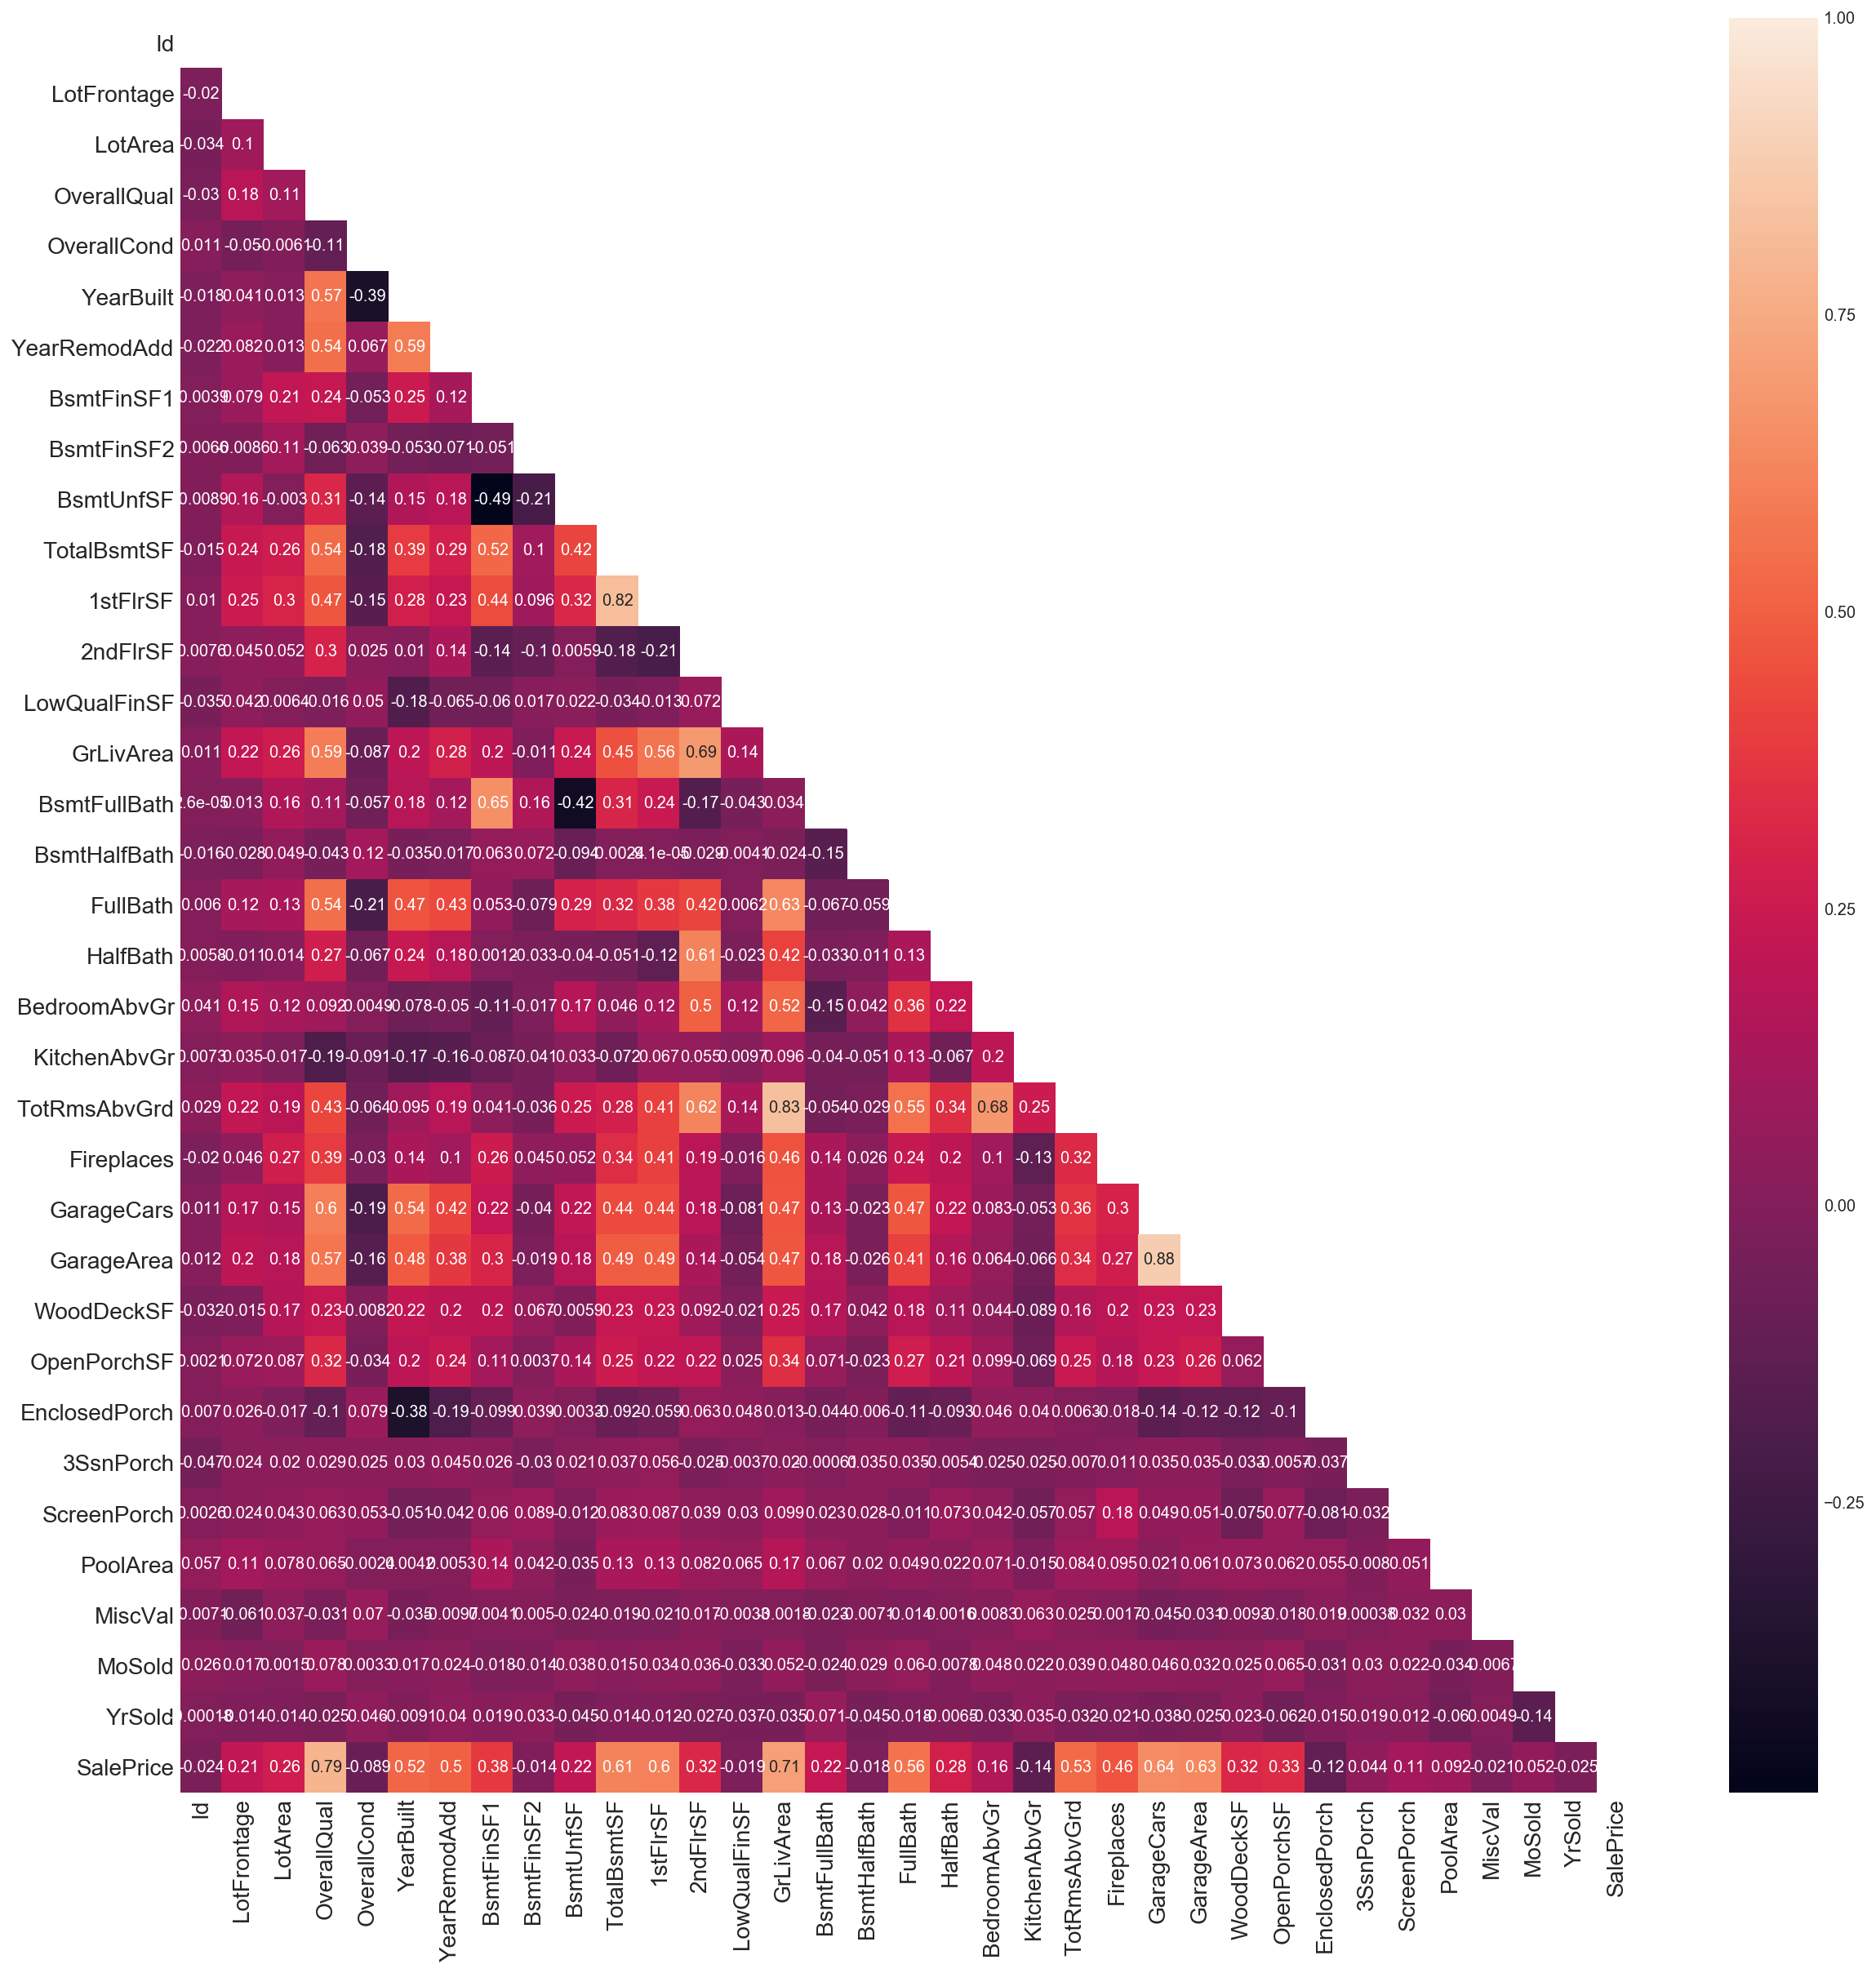

In [41]:
#See heatmap to get a visual on a rough idea whats correlated with SalePrice

corrmap = residential.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(20,20))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrmap, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrmap, mask=mask, annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
plt.show()

#### From the heatmap: GrLivArea is our top candidate.

In [42]:
# Find most important features relative to target
print("Top Correlations to SalePrice")
corr = residential.corr()
corr.sort_values('SalePrice', ascending = False, inplace = True)
corr.SalePrice.head(20) ## Top 20

Top Correlations to SalePrice


SalePrice       1.000000
OverallQual     0.789031
GrLivArea       0.708658
GarageCars      0.642135
GarageArea      0.629831
TotalBsmtSF     0.612088
1stFlrSF        0.603300
FullBath        0.556674
TotRmsAbvGrd    0.533355
YearBuilt       0.517602
YearRemodAdd    0.501186
Fireplaces      0.463264
BsmtFinSF1      0.384475
OpenPorchSF     0.329491
WoodDeckSF      0.320770
2ndFlrSF        0.319774
HalfBath        0.280882
LotArea         0.264715
BsmtFullBath    0.224054
BsmtUnfSF       0.216152
Name: SalePrice, dtype: float64

### SalePrice Distribution

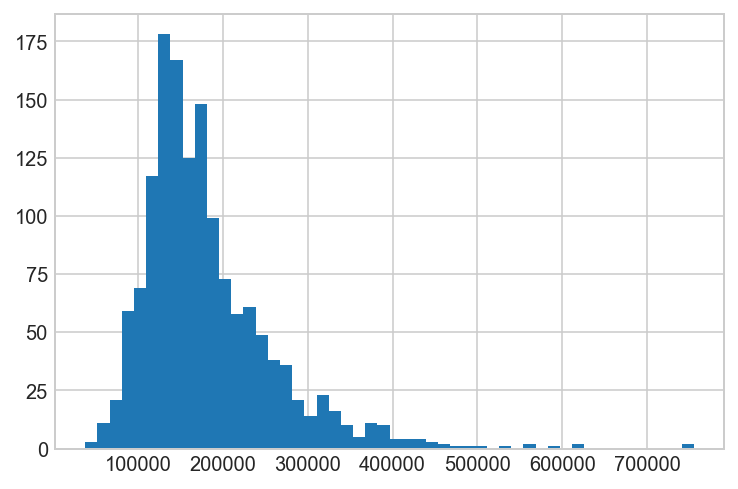

In [43]:
## See Distributions
residential.SalePrice.hist(bins=50)

## Skewed right, not sure if theres any use for us to log.

### OverallQual and SalePrice: Lets see

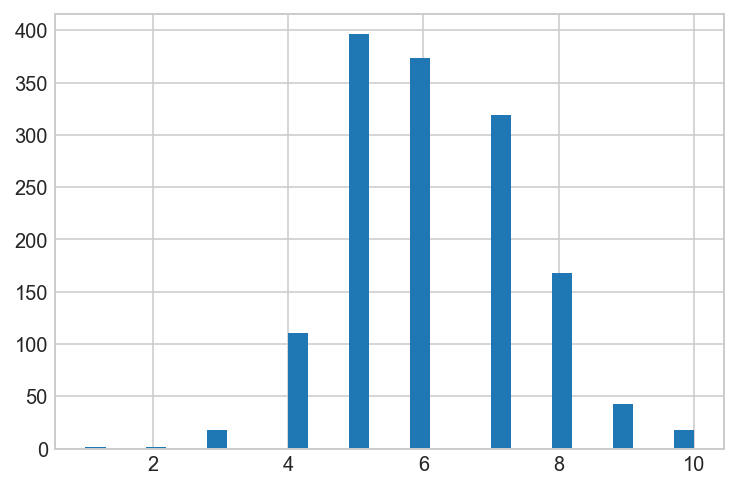

In [44]:
## See Distributions for OverallQual
## OverallQual is a 'Rank' -> Was not converted to astype('str') above; as its quite indicative of the SalePrice
residential.OverallQual.hist(bins=30)

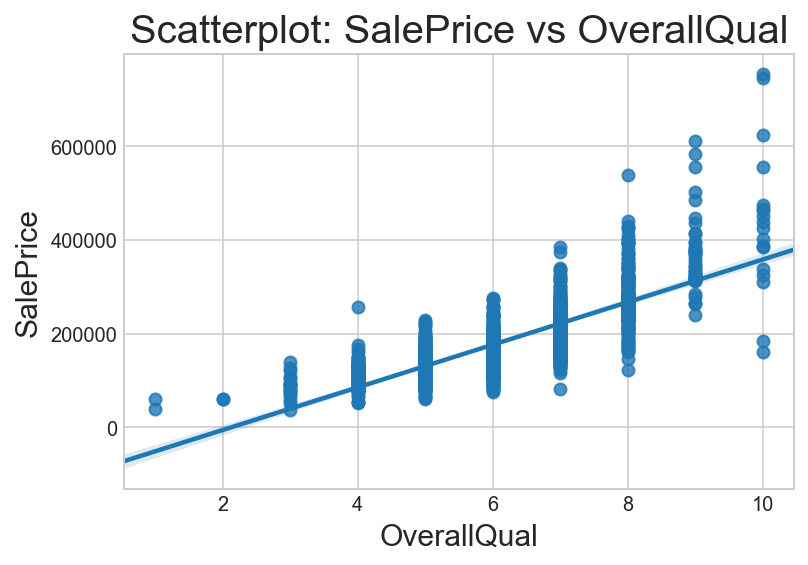

In [45]:
# ## See Scatterplot
fig, ax = plt.subplots()
## USING REGPLOT: Can see with the 'best fit' line
sns.regplot(x='OverallQual', y='SalePrice', data=residential)
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('OverallQual', fontsize=15)
plt.title('Scatterplot: SalePrice vs OverallQual', fontsize=20)
plt.show()

## Higher Quality related to Higher SalePrice! (Wow DataScience!)

### GrLivingArea and SalePrice: Lets see

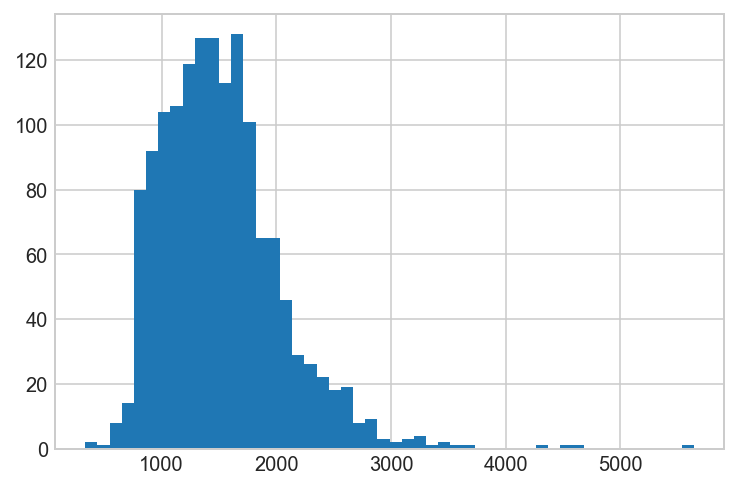

In [46]:
## See Distributions
residential.GrLivArea.hist(bins=50)

## Skewed right, not sure if theres any use for us to log.
## GrLivingArea and SalePrice have a 'similar' distribution..

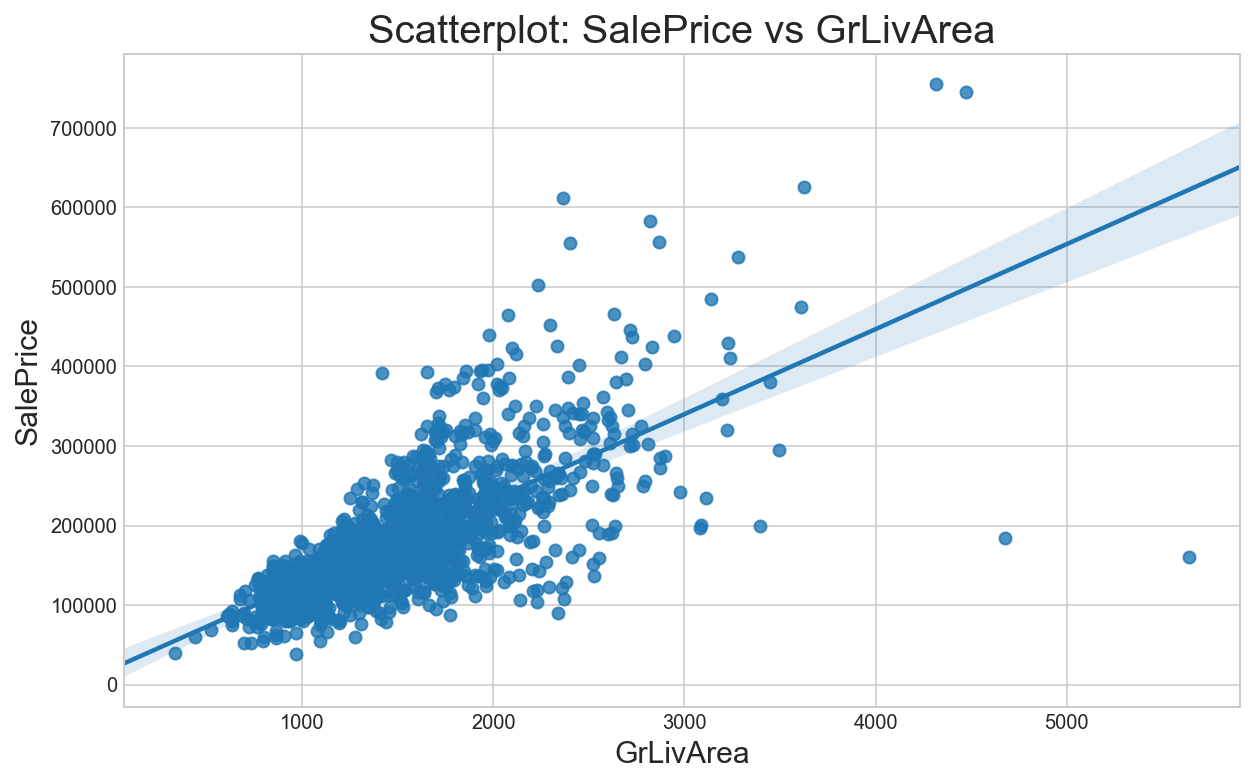

In [47]:
# ## See Scatterplot
fig, ax = plt.subplots(figsize=(10,6))
# ax.scatter(x = residential['GrLivArea'], y = residential['SalePrice'])
## USING REGPLOT: Can see with the 'best fit' line
sns.regplot(x='GrLivArea', y='SalePrice', data=residential)
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.title('Scatterplot: SalePrice vs GrLivArea', fontsize=20)
plt.show()

In [48]:
### 4 Outliers: Way off the best-fit line
residential[residential.GrLivArea > 4000]

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
523    524         60       RL          130    40094   Pave    NA      IR1   
691    692         60       RL          104    21535   Pave    NA      IR1   
1182  1183         60       RL          160    15623   Pave    NA      IR1   
1298  1299         60       RL          313    63887   Pave    NA      IR3   

     LandContour Utilities    ...     PoolArea PoolQC  Fence MiscFeature  \
523          Bnk    AllPub    ...            0     NA     NA          NA   
691          Lvl    AllPub    ...            0     NA     NA          NA   
1182         Lvl    AllPub    ...          555     Ex  MnPrv          NA   
1298         Bnk    AllPub    ...          480     Gd     NA          NA   

     MiscVal MoSold YrSold  SaleType  SaleCondition  SalePrice  
523        0     10   2007       New        Partial     184750  
691        0      1   2007        WD         Normal     755000  
1182       0      7   2007        WD        Abnorml     745000  
1298       0      1   2008       New        Partial     160000  

[4 rows x 81 columns]

In [49]:
## Drop Outliers
outliers = residential[residential.GrLivArea > 4000]

residential = residential.drop(outliers.index, axis=0)

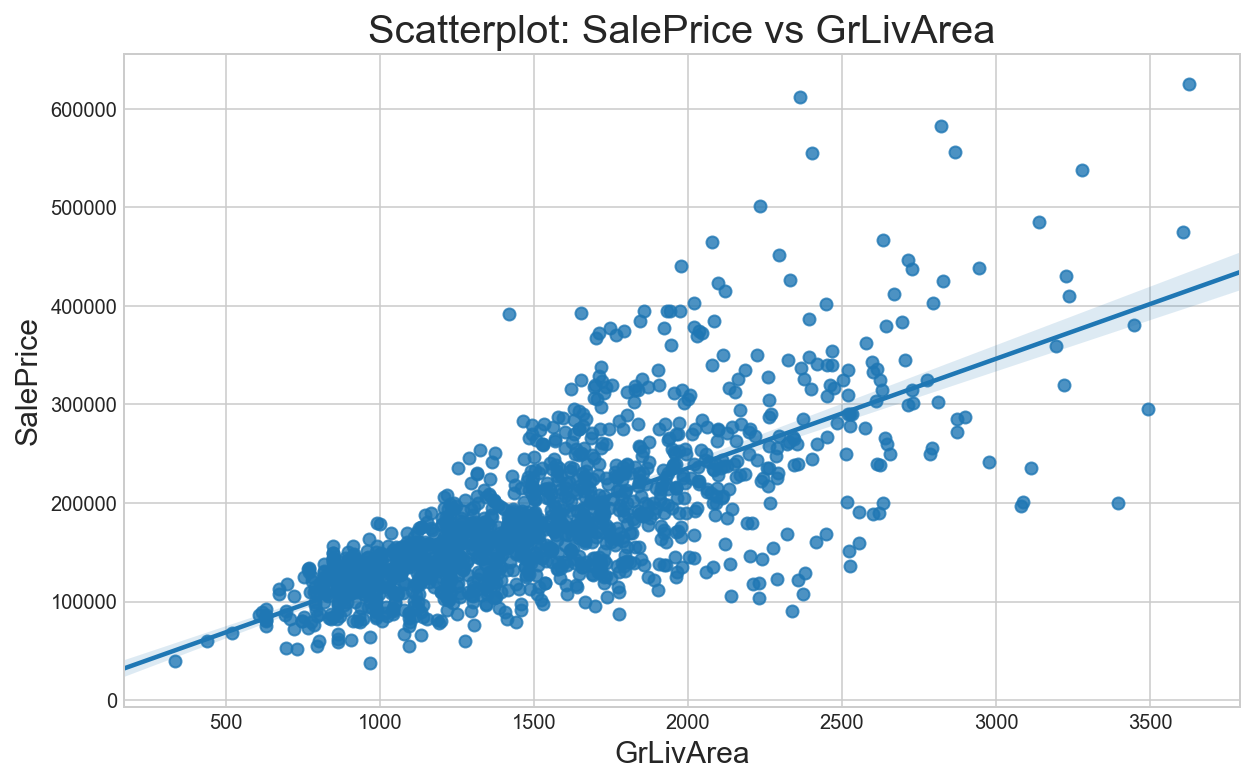

In [50]:
## Check
# ## See Scatterplot
fig, ax = plt.subplots(figsize=(10,6))
# ax.scatter(x = residential['GrLivArea'], y = residential['SalePrice'])
## USING REGPLOT: Can see with the 'best fit' line
sns.regplot(x='GrLivArea', y='SalePrice', data=residential)
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.title('Scatterplot: SalePrice vs GrLivArea', fontsize=20)
plt.show()

## OK Back to building the estimator

In [51]:
# Find most important NON-CATEGORICAL features relative to target
print("Top NON-CATEGORICAL Correlations to SalePrice")
corr = residential.corr()
corr.sort_values('SalePrice', ascending = False, inplace = True)
corr.SalePrice.head(11) ## Top 10 , 11 includes SalePrice

Top NON-CATEGORICAL Correlations to SalePrice


SalePrice       1.000000
OverallQual     0.798954
GrLivArea       0.720743
GarageCars      0.651195
TotalBsmtSF     0.645274
GarageArea      0.643874
1stFlrSF        0.622735
FullBath        0.554926
TotRmsAbvGrd    0.537203
YearBuilt       0.530009
YearRemodAdd    0.515539
Name: SalePrice, dtype: float64

### List down the 'cannot be renovated' features + Justification

<b>Selected from Top 10 NON-CATEGORICAL Correlations to SalePrice first.:</b>
<ol>
<li>'OverallQual'&nbsp; - REMOVED : Ordinal quality metric</li>
<li>'GrLivArea'&nbsp; - ADD</li>
<li>'TotalBsmtSF'&nbsp; - ADD</li>
<li>'GarageCars'&nbsp; - REMOVE : Amount of cars should not be an indicator for the Garage, ie: big car vs small cars?</li>
<li>'GarageArea'&nbsp; - ADD</li>
<li>'1stFlrSF'&nbsp; - ADD</li>
<li>'FullBath'&nbsp; - REMOVE : Renovatable</li>
<li>'TotRmsAbvGrd'&nbsp; - REMOVE : GrLivingArea is a reflection of this</li>
<li>'YearBuilt'&nbsp; - ADD</li>
<li>'YearRemodAdd'&nbsp; - ADD</li>
</ol>
<b>Others added to the features:</b>
<ol>
<li>'LotArea'&nbsp; - ADD</li>
<li>'Neighbourhood'&nbsp; - ADD : Diff neighbourhoods command diff price</li>
<li>'BldgType'&nbsp; - ADD : Diff building types also</li>
</ol>


<strong>SaleCondition: Condition of sale&nbsp; - <strong>NOT SURE YET. This may be a first level filter. As only Normal, AdjLand and Alloca would be indicative towards an actual market price prediction for sale price.</strong>
<ol>
<li>
<div>Normal Normal Sale</div>
</li>
<li>
<div>Abnorml Abnormal Sale - &nbsp;trade, foreclosure, short sale</div>
</li>
<li>
<div>AdjLand Adjoining Land Purchase</div>
</li>
<li>Alloca Allocation - two linked properties with separate deeds, typically condo with a garage unit
</li>
<li>
<div>Family Sale between family members</div>
</li>
<li>
<div>Partial Home was not completed when last assessed (associated with New Homes)</div>
</li>
</ol>
</li>
</ol>

In [52]:
residential.SaleCondition.value_counts()

## Remove Partial + Abnormal + Family = 125+96+20= 241 rows.. Can i afford to drop??

## PUT ON HOLD FIRST

Normal     1193
Partial     123
Abnorml      95
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [53]:
no_reno_features_noncat = ['GrLivArea',  #to Log
                            'TotalBsmtSF', #to Log
                            'GarageArea',  #to Log
                            '1stFlrSF',#to Log
                            'YearBuilt',
                            'YearRemodAdd',
                            'LotArea'] #to Log


# ## TO DUMMYOUT.
no_reno_features_cat = ['Neighborhood', 
                        'BldgType'] #BsmtQual is a measure of Bsmt Height

## ALL Non-renovatable Features
no_reno_features = no_reno_features_noncat + no_reno_features_cat
no_reno_features

['GrLivArea',
 'TotalBsmtSF',
 'GarageArea',
 '1stFlrSF',
 'YearBuilt',
 'YearRemodAdd',
 'LotArea',
 'Neighborhood',
 'BldgType']

### LOG the Non-Cats

In [54]:
residential_log = residential.copy()

Text(0.5,1,u'SalePrice - After Log')

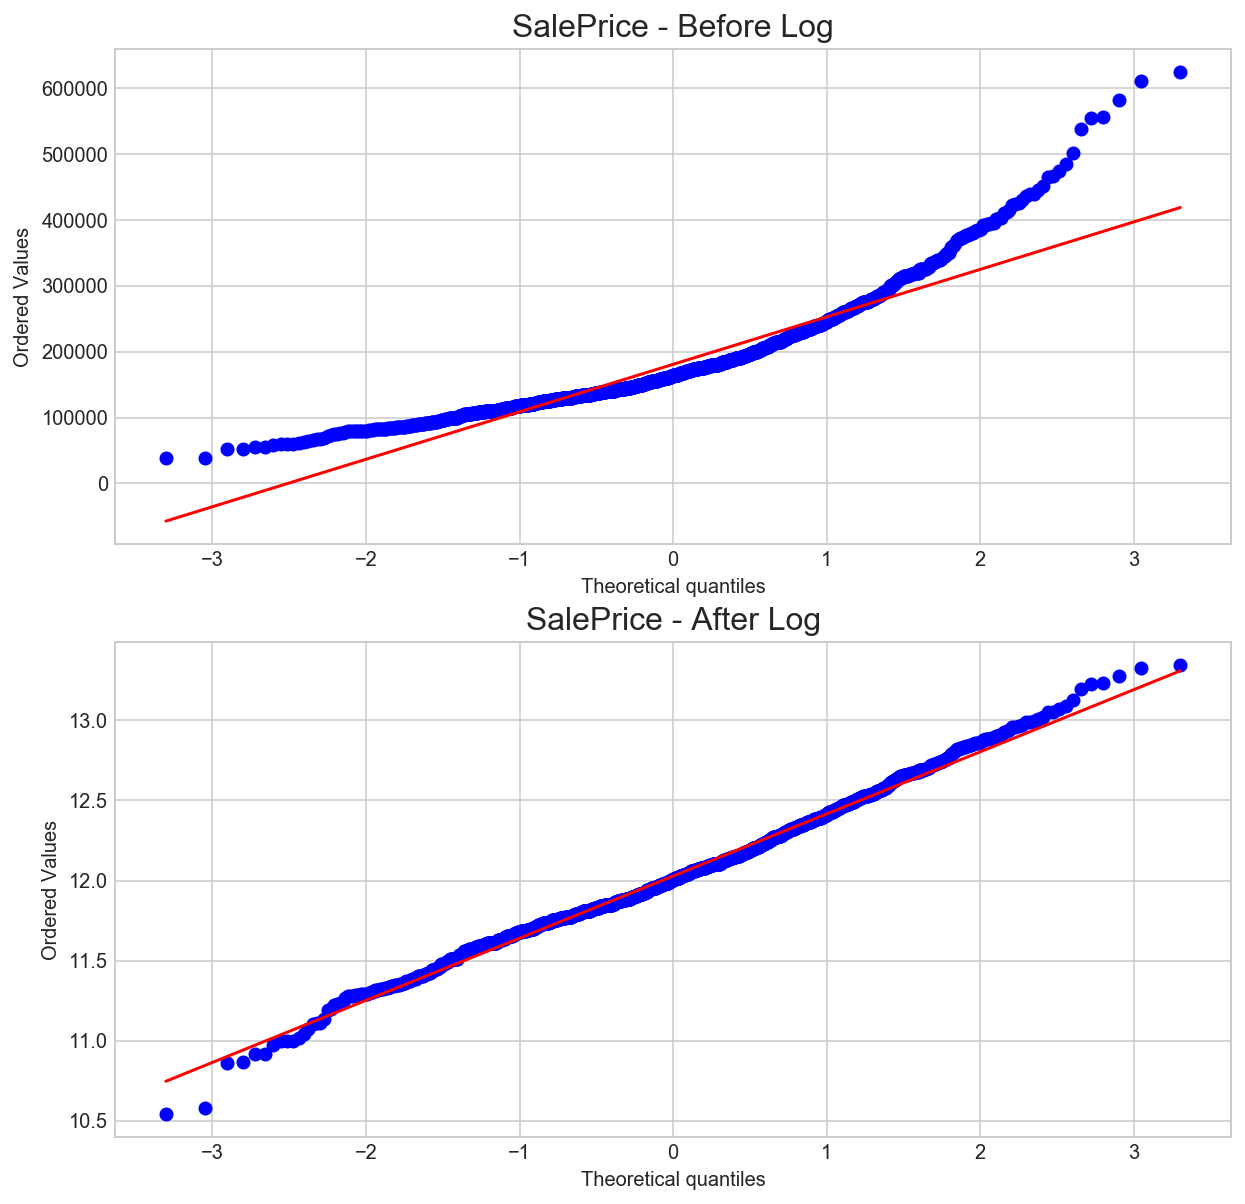

In [55]:
#Log SalePrice
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(residential_log['SalePrice'], plot=ax1)
ax1.set_title('SalePrice - Before Log', fontsize=16)
residential_log['SalePrice'] = np.log(residential_log['SalePrice'])
res = stats.probplot(residential_log['SalePrice'], plot=ax2)
ax2.set_title('SalePrice - After Log', fontsize=16)

Text(0.5,1,u'GrLivArea - After Log')

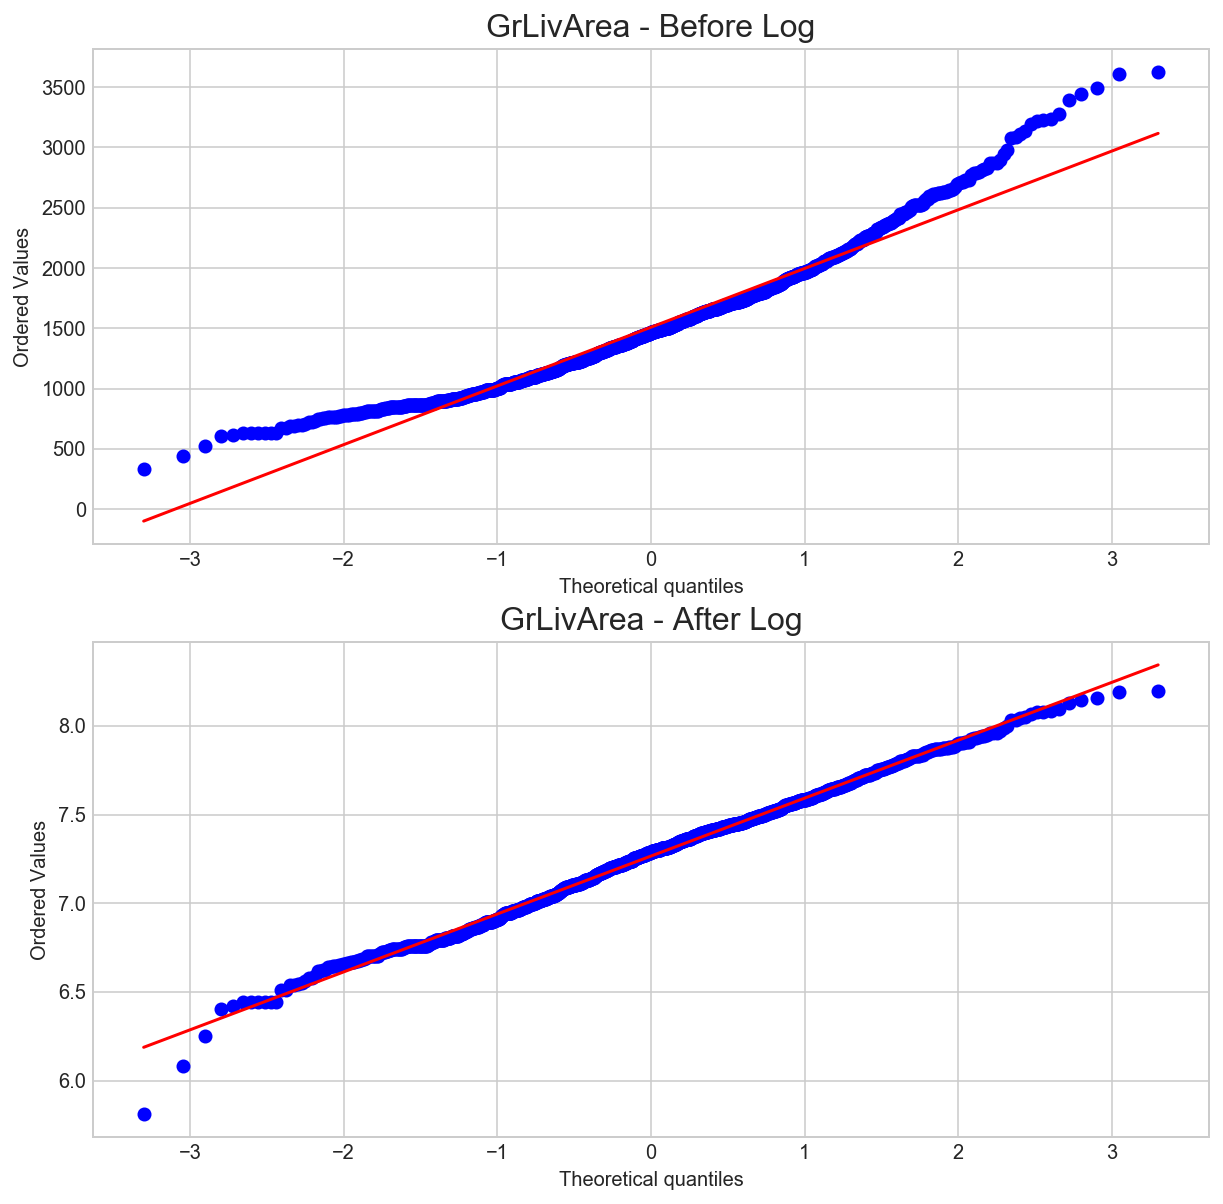

In [56]:
#Log GrLivArea
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(residential_log['GrLivArea'], plot=ax1)
ax1.set_title('GrLivArea - Before Log', fontsize=16)
residential_log['GrLivArea'] = np.log(residential_log['GrLivArea'])
res = stats.probplot(residential_log['GrLivArea'], plot=ax2)
ax2.set_title('GrLivArea - After Log', fontsize=16)

In [57]:
# Function to convert the 0 values int the col to 1. Used when creating a Not-Variable columnn. Ie: GarageArea vs NoGarage
def Zeroconvert(num):
    if num == 0:
        out = 1
    else:
        out = 0
    return out

In [58]:
# So we make a column of 1 and 0s to indicate NoBasement, and then we skip the 0s in the main col
residential_log['NoBsmt'] = residential_log['TotalBsmtSF'].apply(Zeroconvert)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Text(0.5,1,u'TotalBsmtSF - After Log')

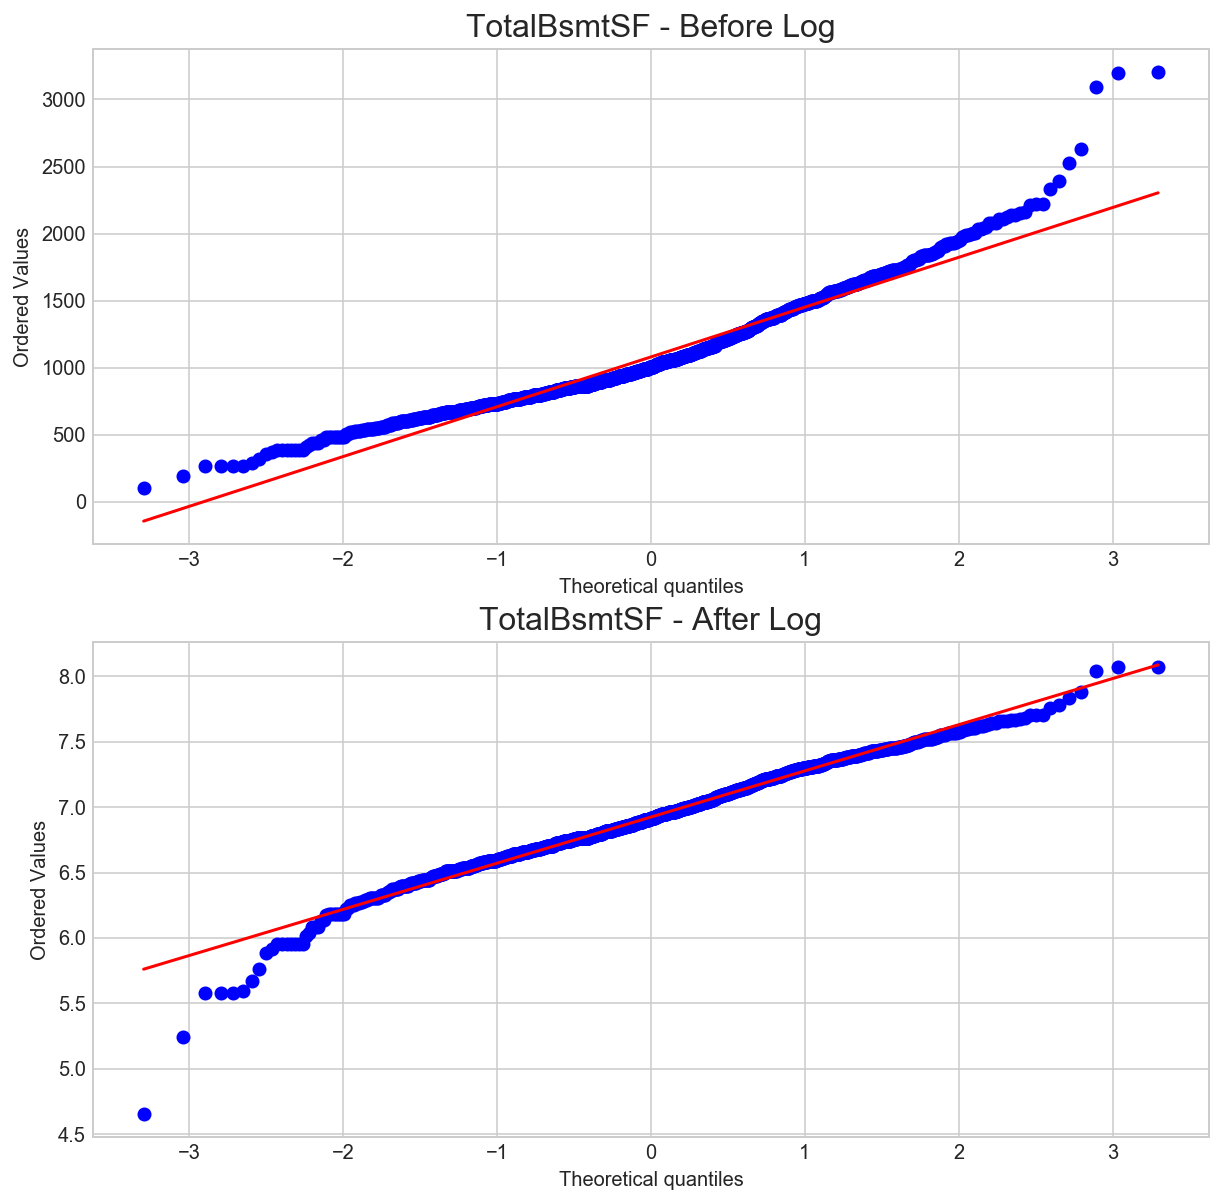

In [59]:
#Log TotalBsmtSF
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(residential_log[residential_log['TotalBsmtSF'] > 0]['TotalBsmtSF'], plot=ax1)
ax1.set_title('TotalBsmtSF - Before Log', fontsize=16)
residential_log.loc[residential_log['NoBsmt'] == 0,'TotalBsmtSF'] = np.log(residential_log['TotalBsmtSF'])
res = stats.probplot(residential_log[residential_log['TotalBsmtSF'] > 0]['TotalBsmtSF'], plot=ax2)
ax2.set_title('TotalBsmtSF - After Log', fontsize=16)

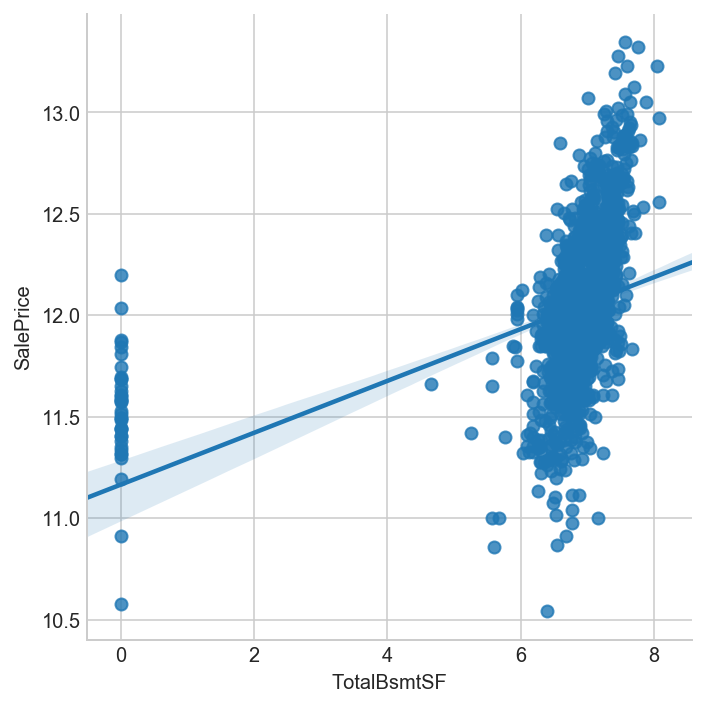

In [60]:
### ADD IN MEDIANS TO ZERO TO SHIFT THE DISTRIBUTION GRADIENT
sns.lmplot(x='TotalBsmtSF', y='SalePrice', data=residential_log)

In [61]:
### CHANGE THE ZEROS TO THE MEDIAN - This shifts the 0s to the main cluster.
TotalBsmtSF_median = np.median(residential_log['TotalBsmtSF'])
print TotalBsmtSF_median
residential_log['TotalBsmtSF'] = residential_log['TotalBsmtSF'].apply(lambda x: TotalBsmtSF_median if x == 0 else x)

6.899723107284872


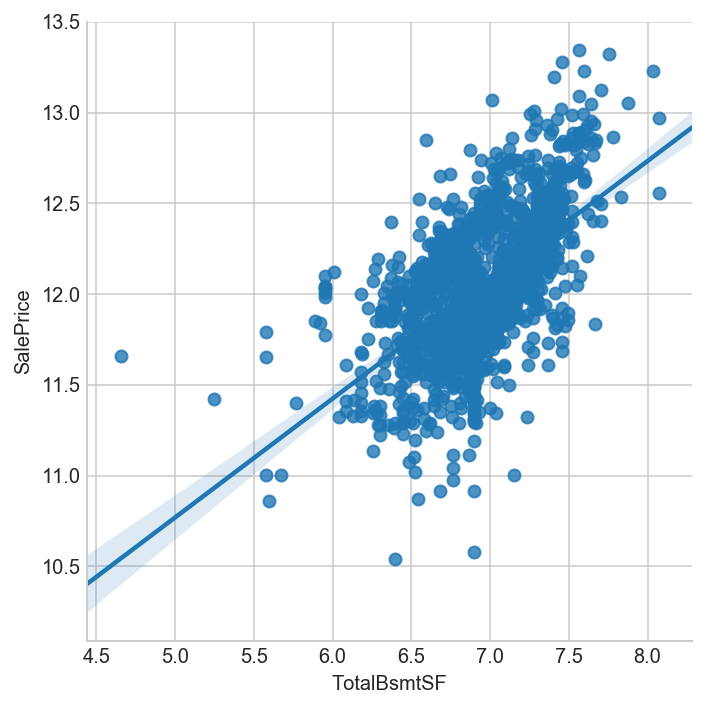

In [62]:
### ADD IN MEDIANS TO ZERO TO SHIFT THE DISTRIBUTION GRADIENT
sns.lmplot(x='TotalBsmtSF', y='SalePrice', data=residential_log)

In [63]:
residential_log['NoGarage'] = residential_log['GarageArea'].apply(Zeroconvert)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Text(0.5,1,u'GarageArea - After Log')

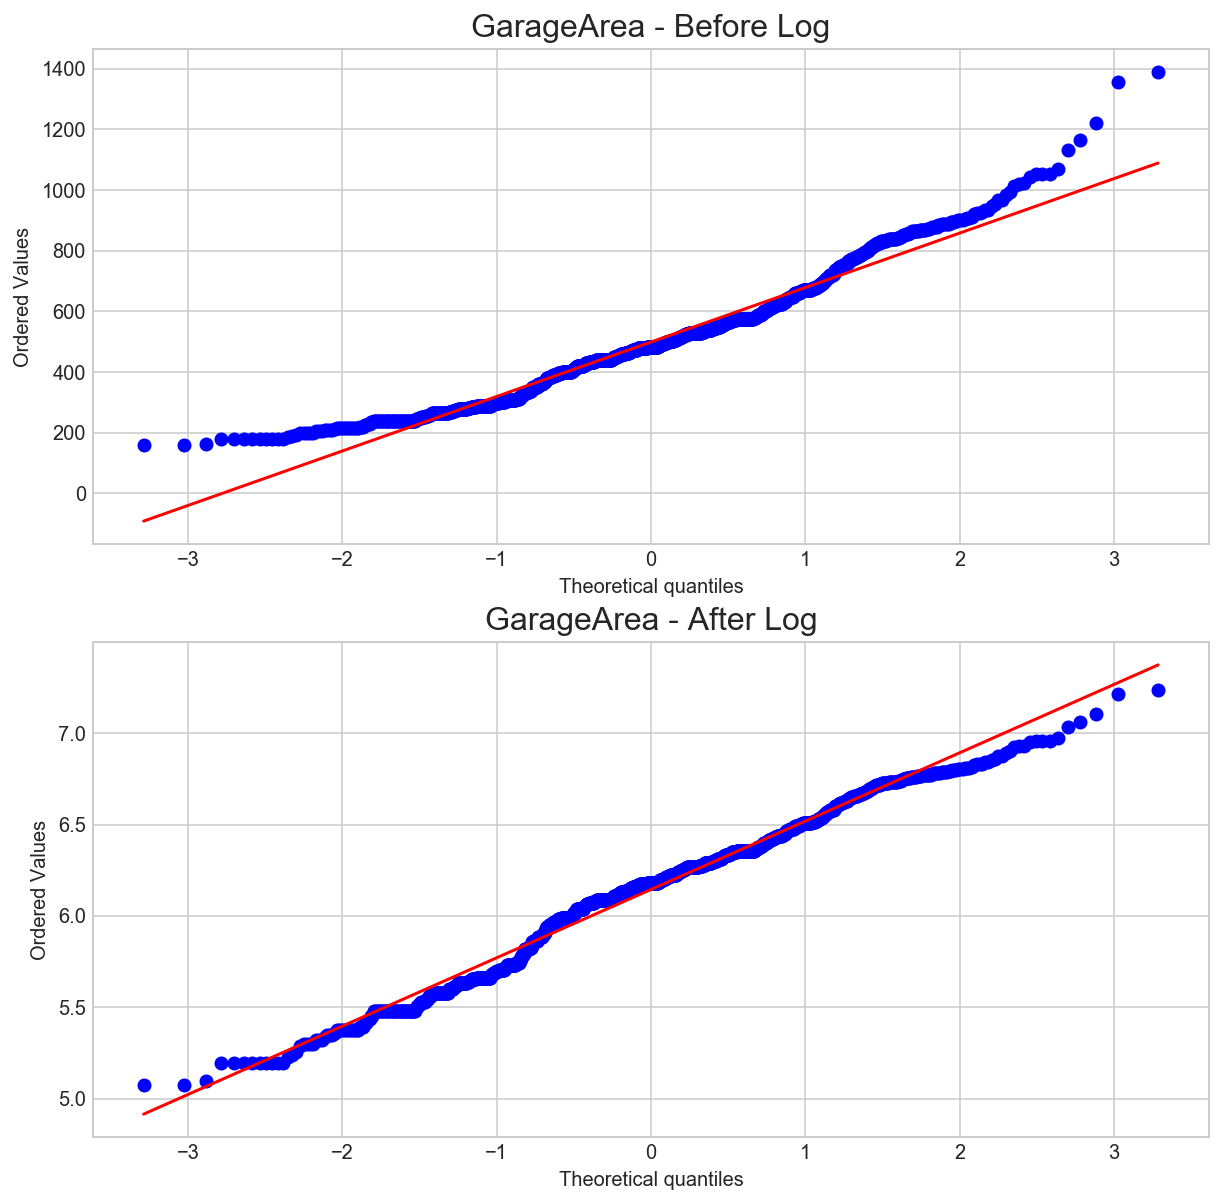

In [64]:
#Log GarageArea
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(residential_log[residential_log['GarageArea'] > 0]['GarageArea'], plot=ax1)
ax1.set_title('GarageArea - Before Log', fontsize=16)
residential_log.loc[residential_log['NoGarage'] == 0,'GarageArea'] = np.log(residential_log['GarageArea'])
res = stats.probplot(residential_log[residential_log['GarageArea'] > 0]['GarageArea'], plot=ax2)
ax2.set_title('GarageArea - After Log', fontsize=16)

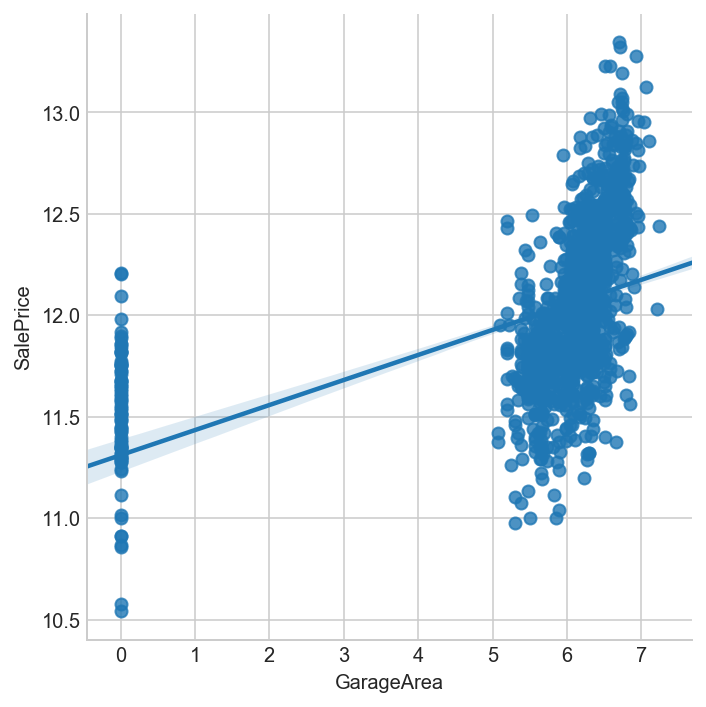

In [65]:
### ADD IN MEDIANS TO ZERO TO SHIFT THE DISTRIBUTION GRADIENT
sns.lmplot(x='GarageArea', y='SalePrice', data=residential_log)

In [66]:
### CHANGE THE ZEROS TO THE MEDIAN
garage_median = np.median(residential_log['GarageArea'])
print garage_median
residential_log['GarageArea'] = residential_log['GarageArea'].apply(lambda x: garage_median if x == 0 else x)

6.170655664951186


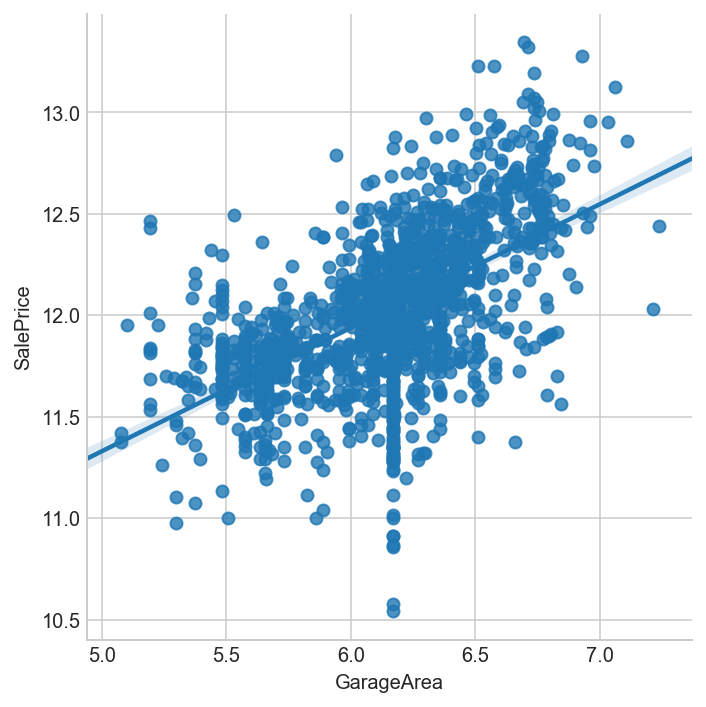

In [67]:
### ADD IN MEDIANS TO ZERO TO SHIFT THE DISTRIBUTION GRADIENT
sns.lmplot(x='GarageArea', y='SalePrice', data=residential_log)

Text(0.5,1,u'1stFlrSF - After Log')

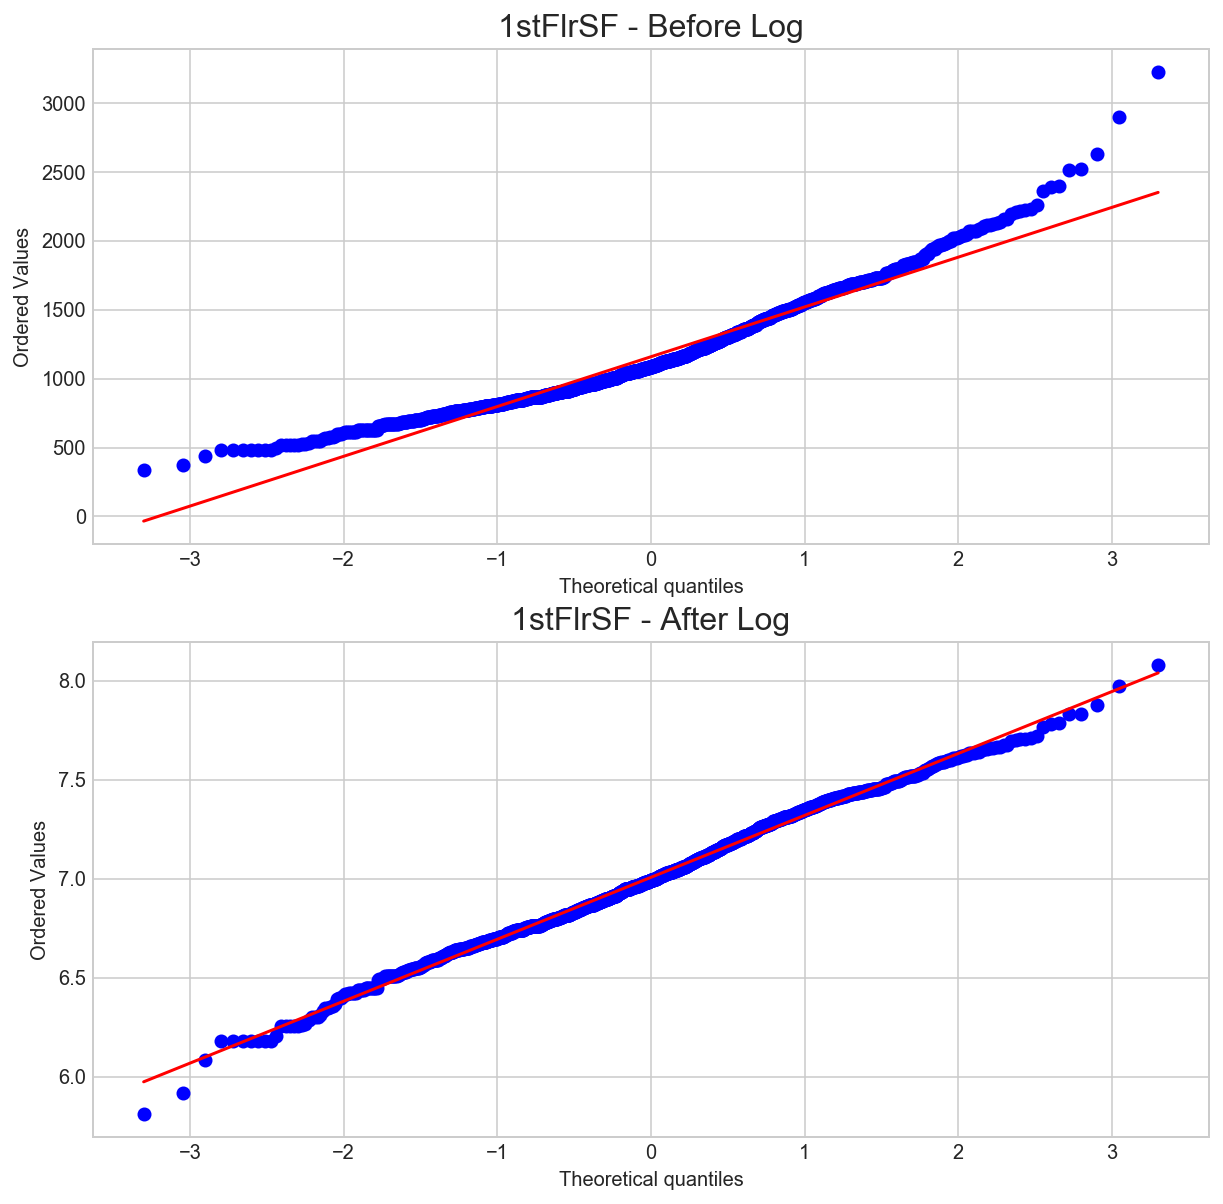

In [68]:
#Log 1stFlrSF
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(residential_log['1stFlrSF'], plot=ax1)
ax1.set_title('1stFlrSF - Before Log', fontsize=16)
residential_log['1stFlrSF'] = np.log(residential_log['1stFlrSF'])
res = stats.probplot(residential_log['1stFlrSF'], plot=ax2)
ax2.set_title('1stFlrSF - After Log', fontsize=16)

Text(0.5,1,u'LotArea - After Log')

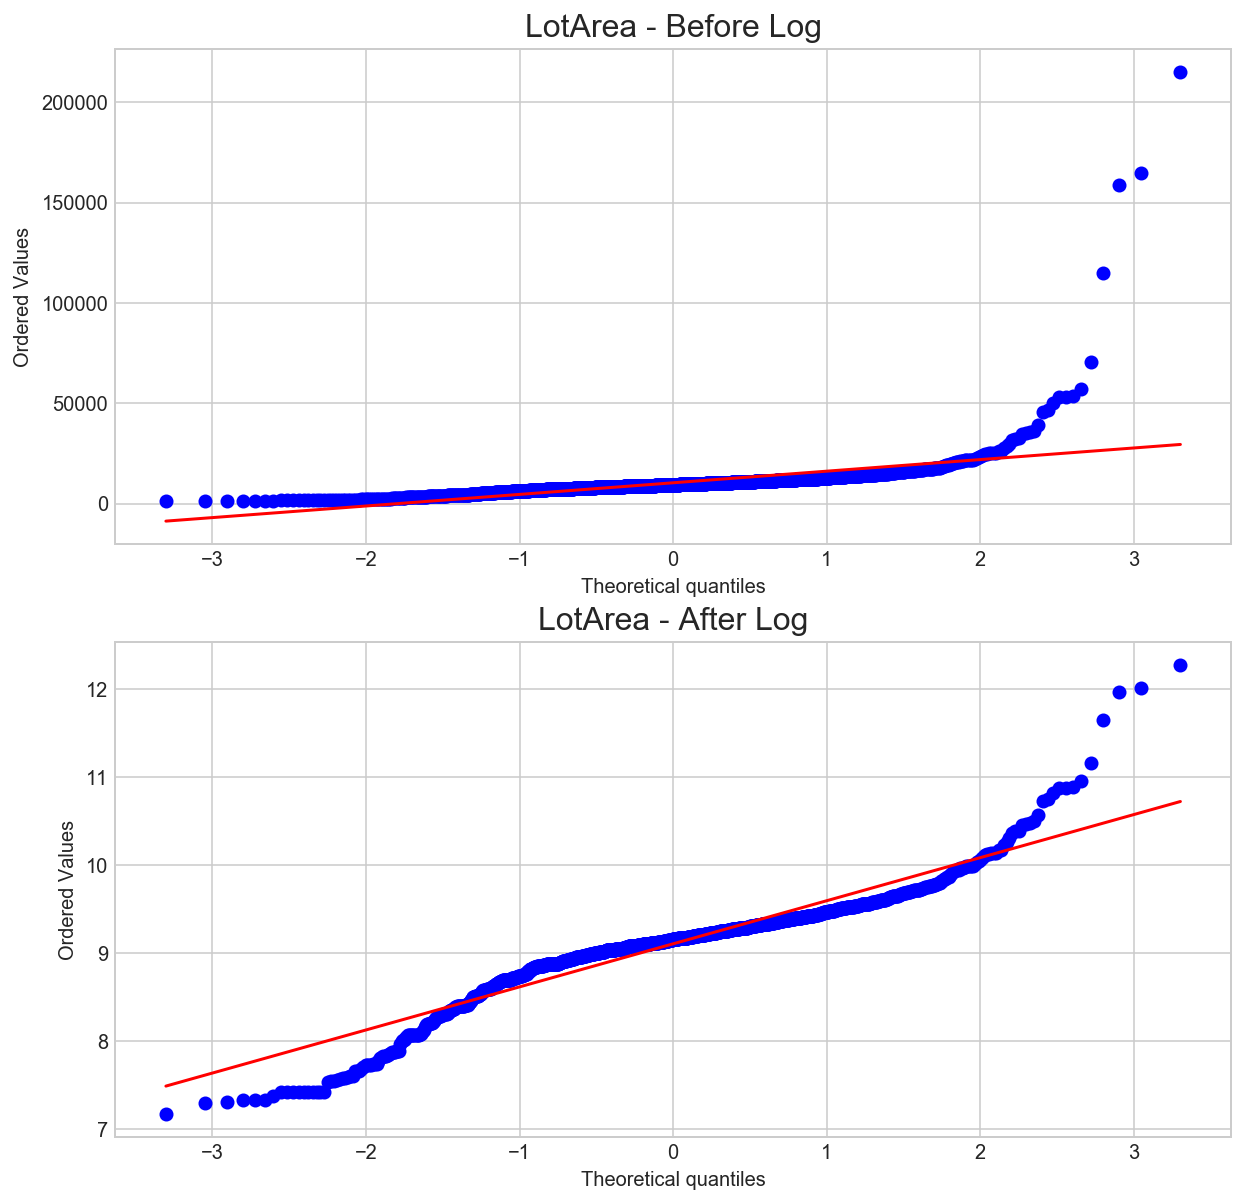

In [69]:
#Log LotArea
f, (ax1, ax2) = plt.subplots(2,figsize=(10,10))
res = stats.probplot(residential_log['LotArea'], plot=ax1)
ax1.set_title('LotArea - Before Log', fontsize=16)
residential_log['LotArea'] = np.log(residential_log['LotArea'])
res = stats.probplot(residential_log['LotArea'], plot=ax2)
ax2.set_title('LotArea - After Log', fontsize=16)

# Train a model on pre-2010 data and evaluate its performance on the 2010 houses.

In [70]:
## Add in SalePrice and YrSold cols.
features = no_reno_features + ['YrSold','SalePrice']+['NoGarage','NoBsmt']

In [71]:
## TRAININGDATA from Residential_log
TRAININGDATA = residential_log[features].copy()

## Dummy out
TRAININGDATA = pd.get_dummies(TRAININGDATA, columns=no_reno_features_cat, drop_first=True)

print TRAININGDATA.shape
##SPLIT THE DATA INTO < 2010 AND == 2010
TESTSET = TRAININGDATA[TRAININGDATA.YrSold == 2010].copy()
TRAINSET = TRAININGDATA[TRAININGDATA.YrSold < 2010].copy()

(1446, 39)


In [72]:
## YrSold served is Purpose, we can drop it.
TESTSET.drop('YrSold', axis=1, inplace=True)
TRAINSET.drop('YrSold', axis=1, inplace=True)

In [73]:
TESTSET.shape

(172, 38)

In [74]:
TRAINSET.shape

(1274, 38)

In [75]:
ss = StandardScaler()

In [76]:
## TRAINING SET
X_train = TRAINSET.drop('SalePrice', axis=1)
X_train = ss.fit_transform(X_train) ##Standardize
y_train = TRAINSET['SalePrice'].values

## TESTING SET
X_test = TESTSET.drop('SalePrice', axis=1)
X_test = ss.fit_transform(X_test) ##Standardize
y_test = TESTSET['SalePrice'].values

## Build Model

### Base LinearRegression cv=15

In [77]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
linreg_scores = cross_val_score(model, X_test, y_test, cv=15)

#print linreg_scores
print('Base Test LinearRegression R2 score: {}'.format(np.mean(linreg_scores)))

Base Test LinearRegression R2 score: -8.79960435476e+22


#### Expected it to be bad, didn't expect it to be this bad

### RidgeCV cv=15

In [79]:
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=15)
optimal_ridge.fit(X_train, y_train)

print('Optimal alpha: {}'.format(optimal_ridge.alpha_))

Optimal alpha: 20.2358964773


### Ridge with optimal_alpha cv=15

In [80]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=15)

#print ridge_scores
print('Ridge R2 score: {}'.format(np.mean(ridge_scores)))

Ridge R2 score: 0.857018492854


In [81]:
# It's vastly better than the linear regression. 
# There's likely so much multicollinearity in the data that linear regression
# overfits and has bogus coefficients on predictors. Ridge is 
# able to manage the multicollinearity and get a good out-of-sample result.

### LassoCV cv=15

In [82]:
optimal_lasso = LassoCV(n_alphas=500, cv=15, verbose=1)
optimal_lasso.fit(X_train, y_train)

print optimal_lasso.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0014228286222284624


..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.0s finished


###  Lasso with optimal_alpha cv=15

In [83]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train, y_train, cv=15)

#print lasso_scores
print('Lasso R2 score: {}'.format(np.mean(lasso_scores)))

Lasso R2 score: 0.857171916454


### Lets try ElasticNet cv=15

In [84]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=15,
                            verbose=1)
optimal_enet.fit(X_train, y_train)

print optimal_enet.alpha_
print optimal_enet.l1_ratio_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.003581533529046626
0.42250000000000004


..............................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:    2.9s finished


In [85]:

## Lets see with the optimals
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_train, y_train, cv=15)

print enet_scores
print np.mean(enet_scores)

[0.90033495 0.8496364  0.89880559 0.90833066 0.83687862 0.86675248
 0.82565664 0.86217746 0.87026117 0.82028931 0.88751662 0.82812823
 0.82951449 0.87777315 0.79581877]
0.857191636272534


### Will go with Lasso, since there isnt much diff in the score.

In [86]:
## Plot to see the Residuals
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

Lasso(alpha=0.0014228286222284624, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [87]:
# Model residuals:
ridge_resid = y_test - ridge.predict(X_test)
lasso_resid = y_test - lasso.predict(X_test)

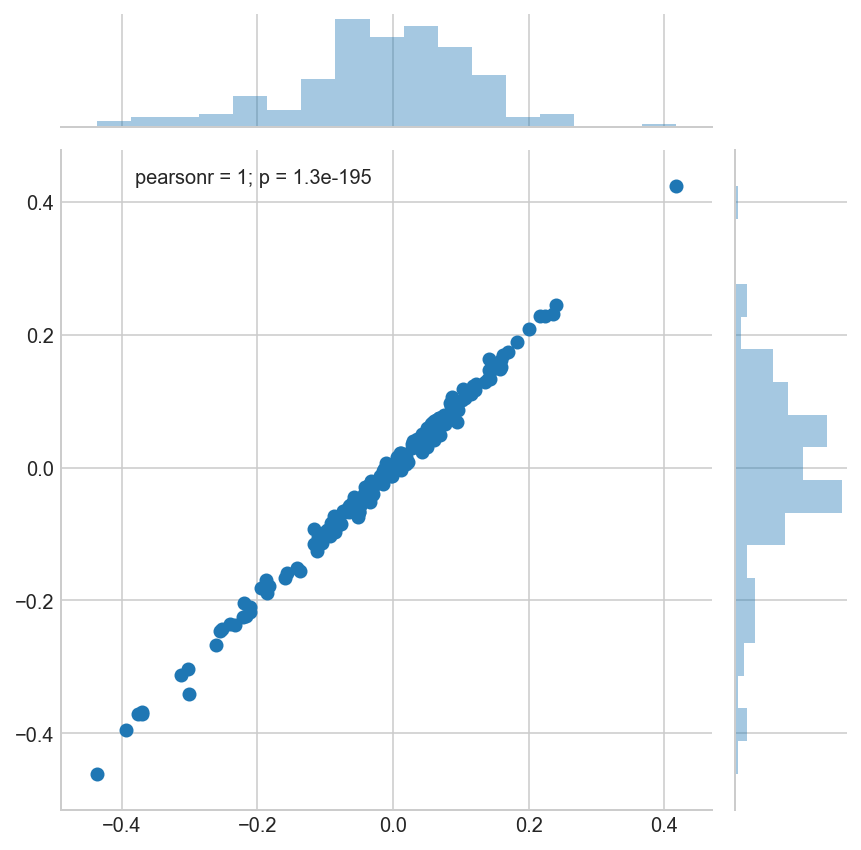

In [88]:
sns.jointplot(ridge_resid, lasso_resid)

## Both seem normally distributed..and quite linear..

###  Lets go with Lasso

In [89]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.0014228286222284624, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [90]:
## See the coefficents of the lasso. (Take notice of the 0 coefs)
lasso_coefs = pd.DataFrame({'variable':TRAINSET.drop('SalePrice', axis=1).columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs

abs_coef      coef              variable
0   0.157574  0.157574             GrLivArea
4   0.085709  0.085709             YearBuilt
5   0.063794  0.063794          YearRemodAdd
6   0.053247  0.053247               LotArea
1   0.053115  0.053115           TotalBsmtSF
24  0.040658  0.040658  Neighborhood_NridgHt
14  0.037334  0.037334  Neighborhood_Crawfor
7   0.031876 -0.031876              NoGarage
2   0.030728  0.030728            GarageArea
30  0.030113  0.030113  Neighborhood_StoneBr
34  0.028363 -0.028363       BldgType_Duplex
8   0.027745 -0.027745                NoBsmt
23  0.021567  0.021567  Neighborhood_NoRidge
29  0.015372  0.015372  Neighborhood_Somerst
32  0.012837  0.012837  Neighborhood_Veenker
11  0.010830  0.010830  Neighborhood_BrkSide
25  0.010736 -0.010736  Neighborhood_OldTown
15  0.010346 -0.010346  Neighborhood_Edwards
27  0.007461 -0.007461   Neighborhood_Sawyer
31  0.007399  0.007399   Neighborhood_Timber
19  0.007396 -0.007396  Neighborhood_Mitchel
16  0.006118 -0.006118  Neighborhood_Gilbert
35  0.006034 -0.006034        BldgType_Twnhs
33  0.005826 -0.005826       BldgType_2fmCon
21  0.004696  0.004696  Neighborhood_NPkVill
3   0.004569  0.004569              1stFlrSF
22  0.003258 -0.003258   Neighborhood_NWAmes
28  0.002419 -0.002419  Neighborhood_SawyerW
17  0.002167 -0.002167   Neighborhood_IDOTRR
9   0.001932  0.001932  Neighborhood_Blueste
26  0.001606  0.001606    Neighborhood_SWISU
13  0.001233 -0.001233  Neighborhood_CollgCr
18  0.001184 -0.001184  Neighborhood_MeadowV
20  0.000000  0.000000    Neighborhood_NAmes
12  0.000000  0.000000  Neighborhood_ClearCr
10  0.000000  0.000000   Neighborhood_BrDale
36  0.000000 -0.000000       BldgType_TwnhsE

In [91]:
print 'Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_))

Percent variables zeroed out: 0.10810810810810811


## Revisit LinearRegression only using Lasso's non-zero features.

In [92]:
lasso_selected_feat = lasso_coefs[lasso_coefs.abs_coef != 0]['variable'].tolist()

In [93]:
## Add in SalePrice and YrSold cols.
features_v2 = lasso_selected_feat + ['YrSold','SalePrice']

In [94]:
## TRAININGDATA2 from TRAININGDATA
## (Reminder: TRAININGDATA IS ALREADY DUMMIED. EVERYTHING WAS DONE WITH DUMMIED OUT COLS)
TRAININGDATA2 = TRAININGDATA[features_v2].copy()

##SPLIT THE DATA INTO < 2010 AND == 2010
TESTSET2 = TRAININGDATA2[TRAININGDATA2.YrSold == 2010].copy()
TRAINSET2 = TRAININGDATA2[TRAININGDATA2.YrSold < 2010].copy()

In [95]:
## YrSold served is Purpose, we can drop it.
TESTSET2.drop('YrSold', axis=1, inplace=True)
TRAINSET2.drop('YrSold', axis=1, inplace=True)

### TRAINSET2 & TESTSET2 !

In [96]:
## TRAINING SET 2
X_train2 = TRAINSET2.drop('SalePrice', axis=1)
X_train2 = ss.fit_transform(X_train2) ##Standardize
y_train2 = TRAINSET2['SalePrice'].values

## TESTING SET 2
X_test2 = TESTSET2.drop('SalePrice', axis=1)
X_test2 = ss.fit_transform(X_test2) ##Standardize
y_test2 = TESTSET2['SalePrice'].values

In [97]:
model2 = LinearRegression()
model2.fit(X_train2, y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [98]:
linreg_scores2 = cross_val_score(model2, X_test2, y_test2, cv=11) 
#print linreg_scores
print('LinearRegression with select features after Lasso: R2 score: {}'.format(np.mean(linreg_scores2)))

LinearRegression with select features after Lasso: R2 score: 0.816941461544


## Model trained: Lets try it out

### Lets Predict with X_test2 on model2 !

In [99]:
## Keep fingers crossed.
y_pred = model2.predict(X_test2)

In [100]:
print('Mean squared error: {}'.format(mean_squared_error(y_test2, y_pred)))
print('Model Score R2: {}'.format(model2.score(X_test2, y_test2)))
print('Model Intercept: {}'.format(model2.intercept_))
#print('Cross Validated R2: {}'.format(np.mean(cross_val_score(model2, X_test2,y_test2, cv=11))))

Mean squared error: 0.0183188039885
Model Score R2: 0.881804214996
Model Intercept: 12.0299726947


###  Seems good to go!

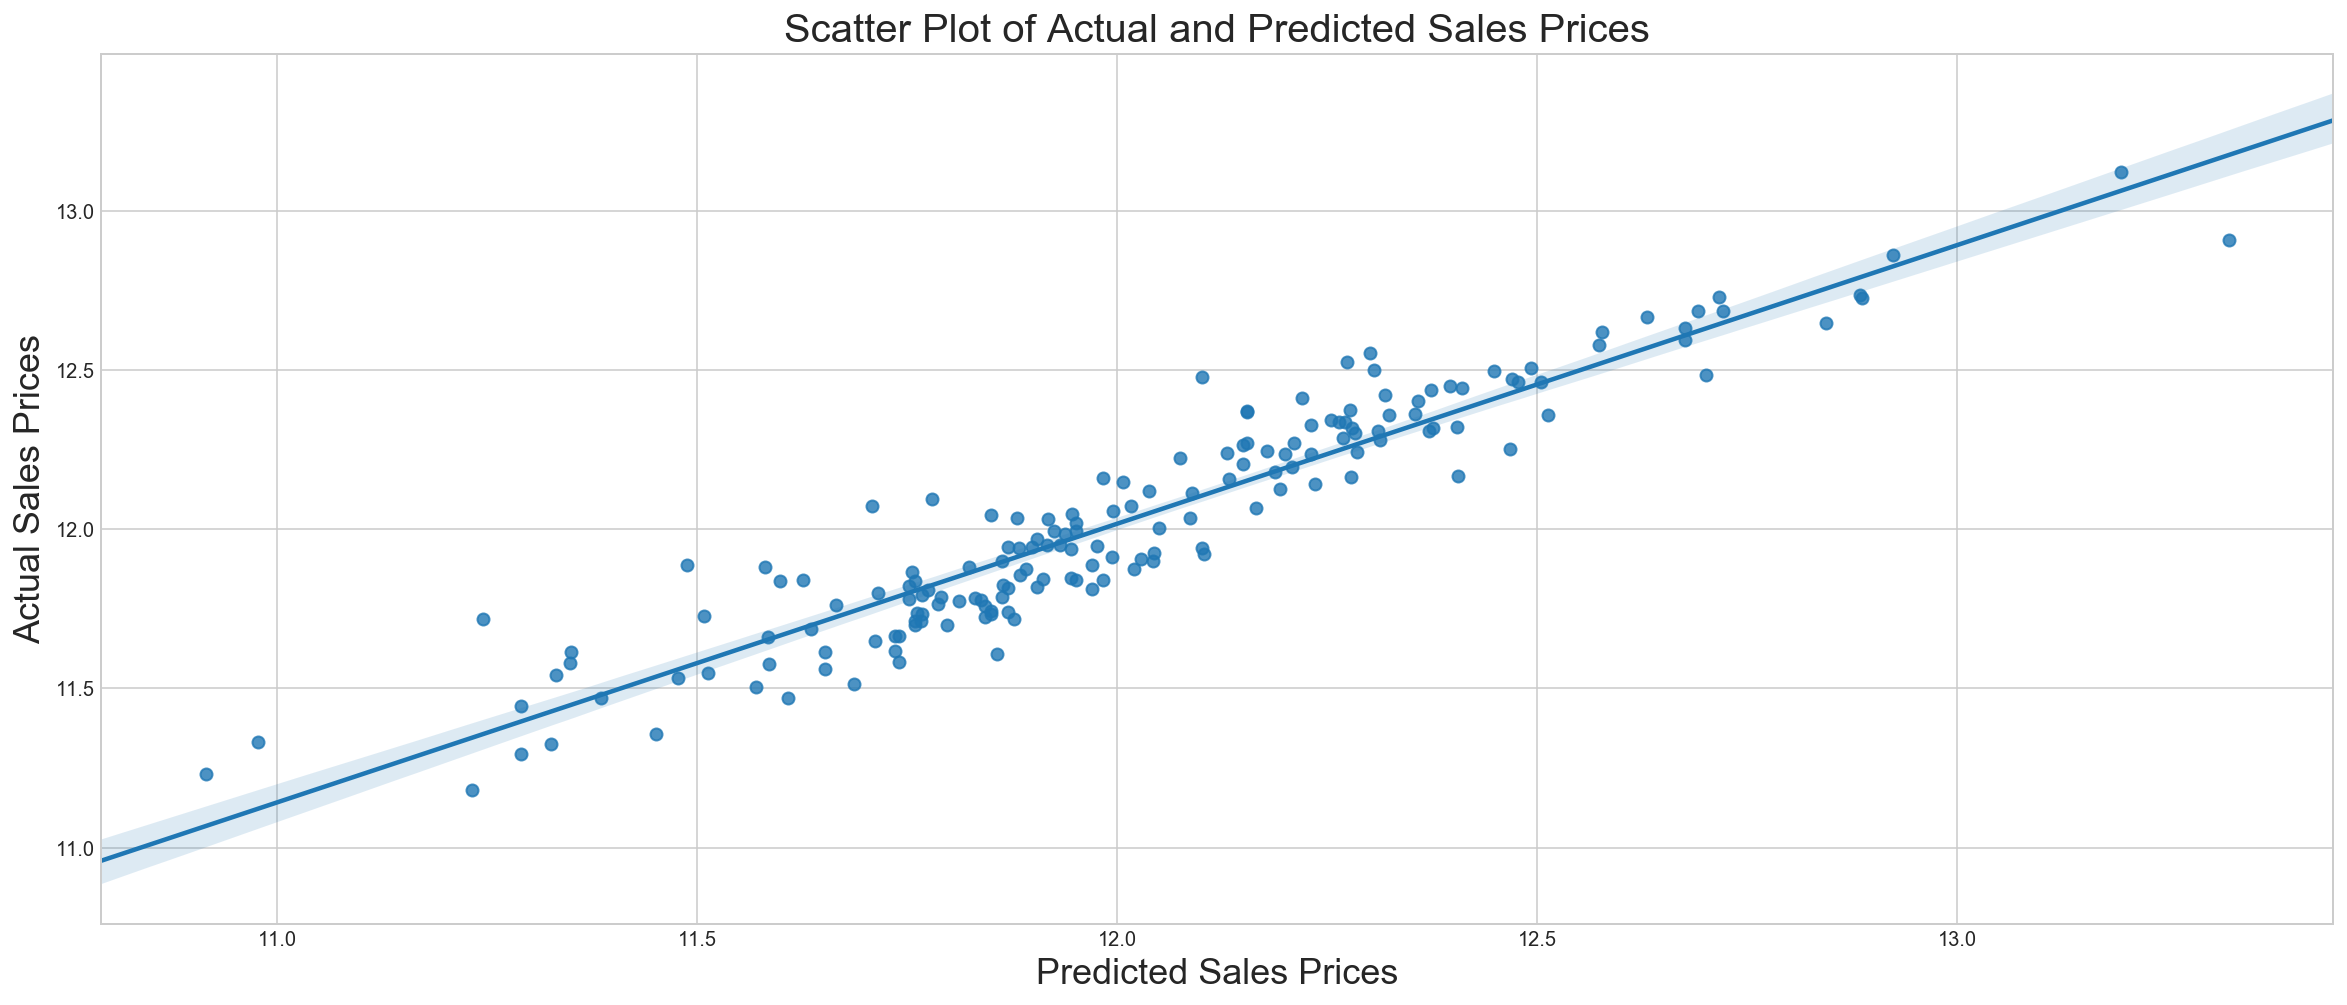

In [101]:
# Plot Actual vs Predicted SalesPrice
plt.figure(figsize=(20,8))
sns.regplot(y_test2, y_pred, fit_reg=True)

plt.title('Scatter Plot of Actual and Predicted Sales Prices', fontsize=20)
plt.xlabel('Predicted Sales Prices', fontsize=18)
plt.ylabel('Actual Sales Prices', fontsize=18)
plt.show()

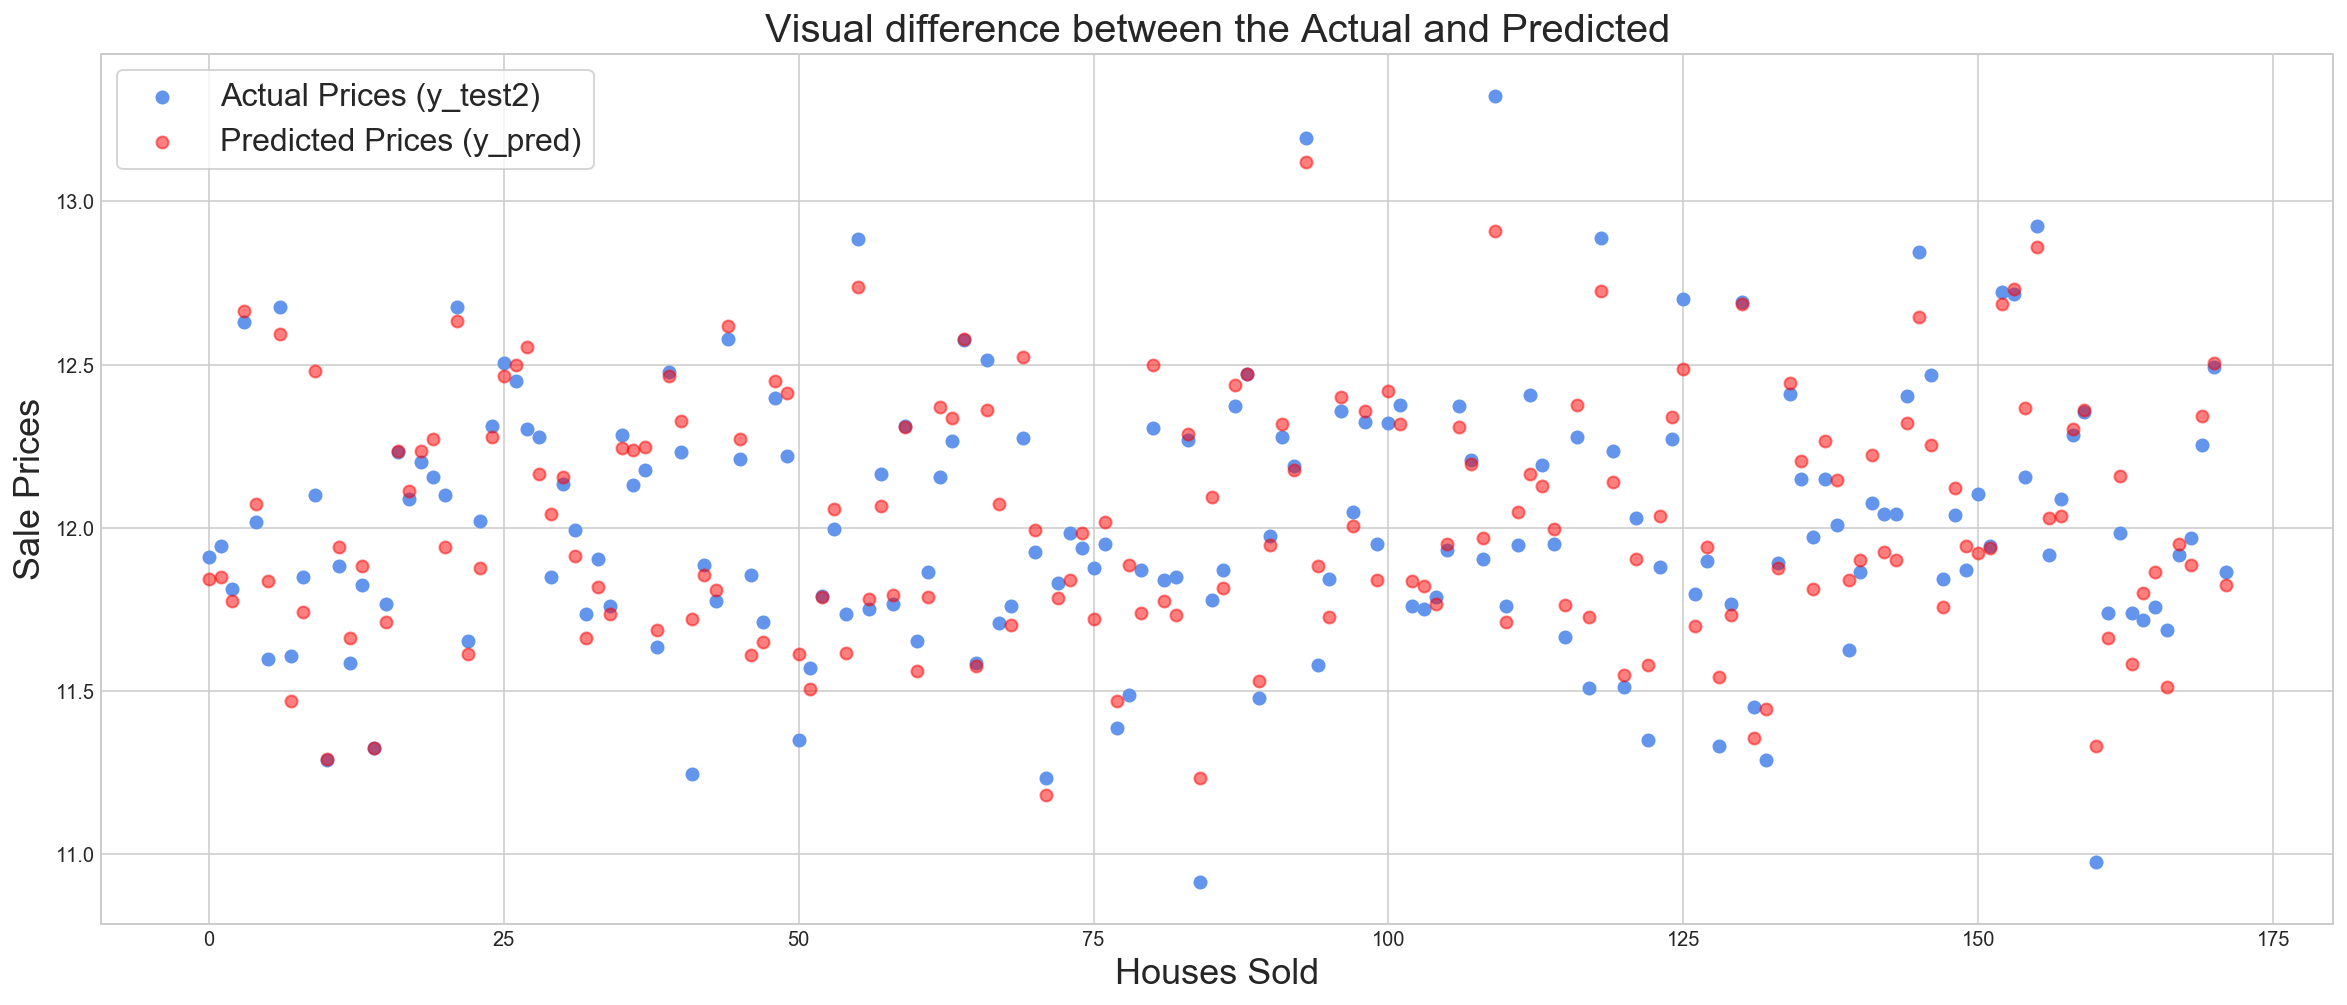

In [102]:
# Plot the Actual(y_test2) and Predicted (y_pred) to see the spread
# BLUE = Actual (y_test2)
# RED =  Predicted (y_pred)

plt.figure(figsize=(20,8))
plt.scatter(range(len(y_test2)), y_test2,  color='cornflowerblue', label='Actual Prices (y_test2)') #Actual (y_test2)
plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.5, label='Predicted Prices (y_pred)') #Predicted (y_pred)

plt.legend(loc='upper left', prop={'size': 16}, frameon=True)

plt.title('Visual difference between the Actual and Predicted', fontsize=20)
plt.xlabel('Houses Sold', fontsize=18)
plt.ylabel('Sale Prices', fontsize=18)
plt.show()

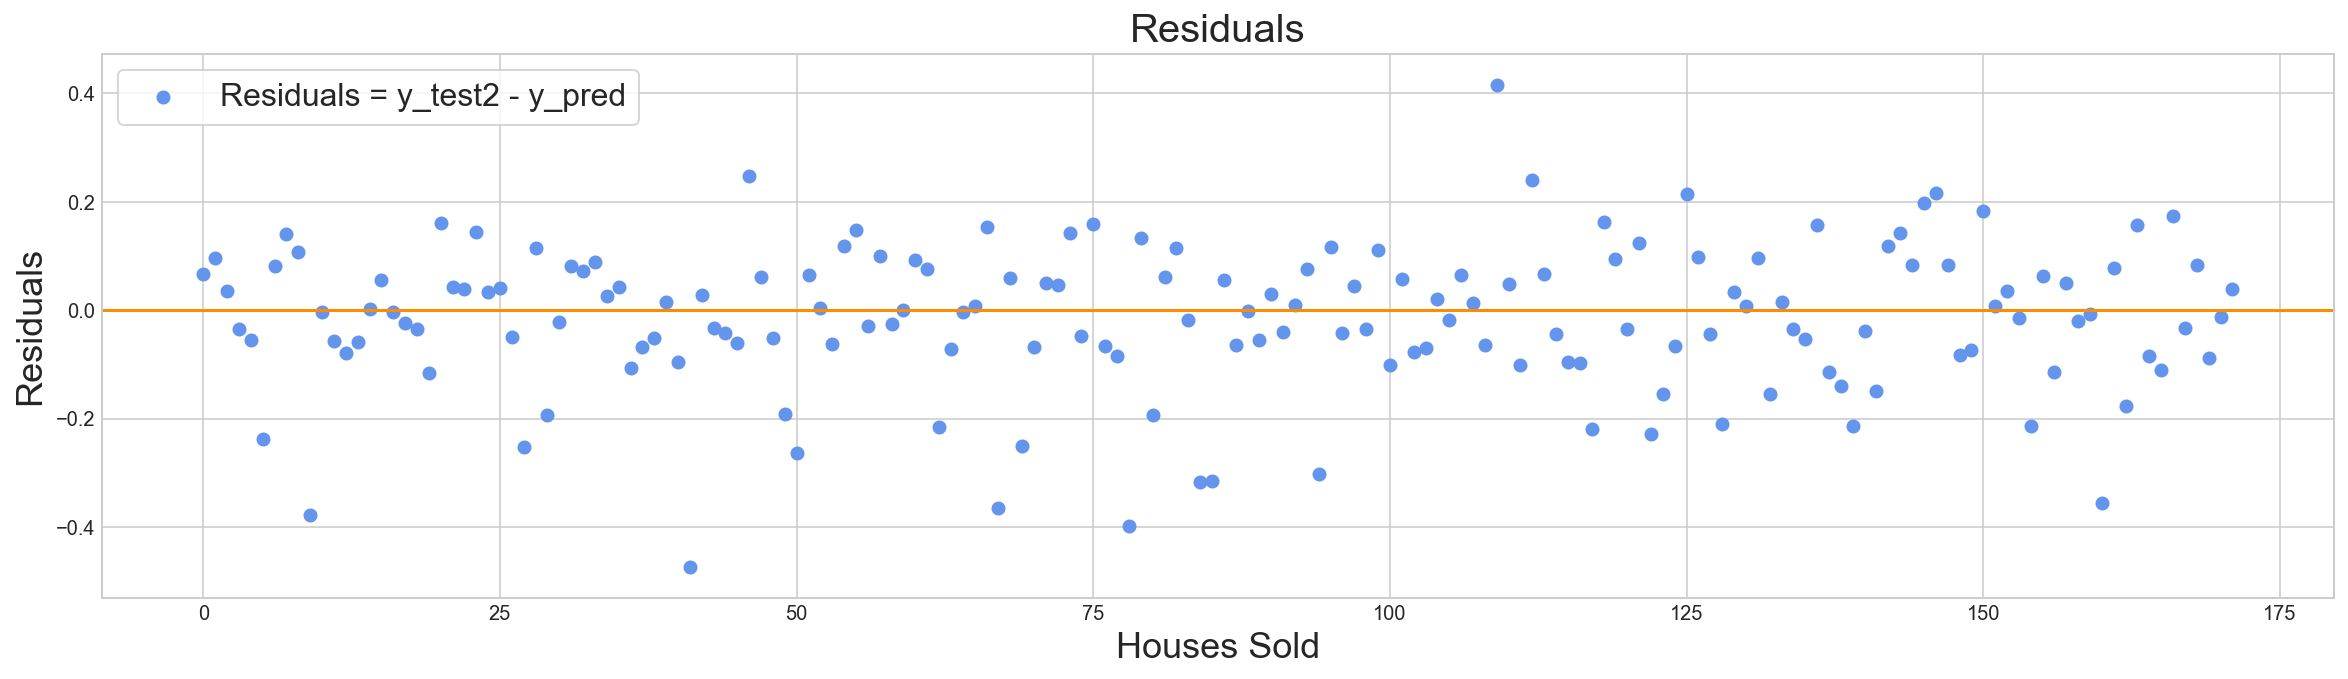

In [103]:
# Plot the Residuals = y_test2 - y_pred  to see the spread
Residuals = y_test2 - y_pred

plt.figure(figsize=(20,5))
plt.scatter(range(len(Residuals)), Residuals,  color='cornflowerblue', label='Residuals = y_test2 - y_pred') #Residuals
#plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.5, label='Predicted Prices (y_pred)') #Predicted (y_pred)

plt.legend(loc='upper left', prop={'size': 16}, frameon=True)

plt.title('Residuals', fontsize=20)
plt.xlabel('Houses Sold', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.axhline(y=0, color='darkorange')  ## the 0 line to see how far the residuals are.
plt.show()

#### The mean of the residuals:

In [104]:
#np.exp(y_pred)
Q1_residuals = y_test2 - y_pred
print('Mean of Predicted Residuals: {}'.format(np.mean(Q1_residuals))) 
print('Median of Predicted Residuals: {}'.format(np.median(Q1_residuals))) 

Mean of Predicted Residuals: -0.0149656465603
Median of Predicted Residuals: -0.00416141709146


<div>
<h3><strong>The LinearRegression model: model2 is ready to be used.</strong></h3>
<ul>
<li><strong>Mean squared error: 0.0178364282937</strong></li>
<li><strong>Model Score R2: 0.884916578334</strong></li>
</ul>
</div>
<div>Given the accuracy of the model, this explains about 88% of the <span style="text-decoration: underline;">predicted price</span>. The rest of the 12% are the unexplained <span style="text-decoration: underline;"> residuals + noise</span>.<br> Which we will explore in Q2</div>
<div>&nbsp;</div>
<div>Things to note:</div>
<ul>
<li>This model is a <em>log-log</em> model.</li>
<li>Please <strong><span style="background-color: #ccffff;">np.exp(y_pred)</span></strong> the predictions, as it was log transformed to use in the model.</li>
</ul>

<h3>Currently what we have from Q1:</h3>
<table style="height: 67px; width: 600px; border-color: #000000;" border="2">
<tbody>
<tr>
<td style="width: 85%; background-color: #d4f442; text-align: center;">Previous model in Q1 explains the predictions: <br />88%</td>
<td style="width: 15%; background-color: #42c5f4; text-align: center;">
<p align="center">Noise<br />+<br />Residuals:<br />12%</p>
</td>
</tr>
</tbody>
</table>
<p>Previous model accounts for 88% of the prediction variable, we try and account for the remaining 12% attributed to the Residuals + Noise.</p>
<ul>
<li><strong>The noise and the residuals are indistinguishable, we cannot differentiate one from the other.</strong></li>
<li>The residuals in the 12% are diluted by the noise.</li>
</ul>
<h3>In Q2 we try to explain the Noise + Residuals of 12%</h3>

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

## Complete the Dataset with Predictions.
### Remember that it is still LOG

#### Predict Whole TRAININGDATA2.

In [105]:
X_whole = TRAININGDATA2.drop(['SalePrice','YrSold'], axis=1)
y_whole_pred = model2.predict(X_whole)

#### Get the Residuals for the whole TRAININGDATA2

In [106]:
y_whole_residual = TRAININGDATA2['SalePrice'] - y_whole_pred

## Build Features for Q2

#### Justify the selection..

In [107]:
#Quality features 1
QualC_cols = [col for col in residential_log.columns if 'QC' in col]
QualC_cols
#(Did not use in the end; they are 'outliers' that will skew the model)

['HeatingQC', 'PoolQC']

In [108]:
#Quality features 2
Qual_cols = [col for col in residential_log.columns if 'Qu' in col]
Qual_cols.remove('LowQualFinSF') # Didn't use it 
Qual_cols.remove('OverallQual') # Ordinal - take out from here, add to the non-dummy
Qual_cols.remove('FireplaceQu') # Didn't use it 
Qual_cols

['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageQual']

In [109]:
#Condition features
Cond_cols = [col for col in residential_log.columns if 'Cond' in col]
Cond_cols.remove('OverallCond') # Ordinal - take out from here, add to the non-dummy
Cond_cols.remove('SaleCondition') # Category, that isn't a house condition
Cond_cols.remove('GarageCond') # Garage accounted for in GarageQual
Cond_cols.remove('Condition1') # Didn't use it 
Cond_cols.remove('Condition2') # Didn't use it 
Cond_cols

['ExterCond', 'BsmtCond']

In [110]:
#Combined Quality and Condition features (To Dummy out)
#qual_cond_features = QualC_cols + Qual_cols + Cond_cols
qual_cond_features = Qual_cols + Cond_cols

In [111]:
#Selected renovatable features that are categorical (To Dummy out)
renovatable_features_cat = ['Fence', 'FullBath', 'BsmtFullBath', 'BsmtHalfBath']

In [112]:
##Add all Porch as 1 feature (In the end, didn't use porch features at all)
residential_log['PorchSF'] = residential_log[['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis=1)

In [113]:
TO_DUMMY_OUT = qual_cond_features + renovatable_features_cat
reno_features_noncat = ['OverallQual', 'OverallCond'] # Add in Overall metrics

In [114]:
reno_features = reno_features_noncat + TO_DUMMY_OUT
len(reno_features)

12

In [115]:
## Add in SalePrice and YrSold cols.
features_q2 = reno_features + ['YrSold']

## TRAININGDATA from Residential_log
TRAININGDATA_q2 = residential_log[features_q2].copy()

#### ADD in the Residuals Column

In [116]:
TRAININGDATA_q2['residuals'] = y_whole_residual

In [117]:
## Dummy out
TRAININGDATA_q2 = pd.get_dummies(TRAININGDATA_q2, columns=TO_DUMMY_OUT, drop_first=True)

print TRAININGDATA_q2.shape
##SPLIT THE DATA INTO < 2010 AND == 2010
TESTSET_q2 = TRAININGDATA_q2[TRAININGDATA_q2.YrSold == 2010].copy()
TRAINSET_q2 = TRAININGDATA_q2[TRAININGDATA_q2.YrSold < 2010].copy()

## YrSold served is Purpose, we can drop it.
TESTSET_q2.drop('YrSold', axis=1, inplace=True)
TRAINSET_q2.drop('YrSold', axis=1, inplace=True)

(1446, 39)


In [118]:
ss = StandardScaler()

In [119]:
## TRAINING SET Q2
# TRAINING [Training] set for Q2
X_train_q2 = TRAINSET_q2.drop('residuals', axis=1)
X_train_q2 = ss.fit_transform(X_train_q2) ##Standardize
# TRAINING [Test] set for Q2
y_train_q2 = TRAINSET_q2['residuals'].values

## TESTING SET Q2
# TESTING [Training] set for Q2
X_test_q2 = TESTSET_q2.drop('residuals', axis=1)
X_test_q2 = ss.fit_transform(X_test_q2) ##Standardize
# TESTING [Test] set for Q2
y_test_q2 = TESTSET_q2['residuals'].values

## Repeat! Build Model for Predicting the Residuals from above to explain the reno-features

### Baseline LinearRegression cv=15

In [120]:
model_q2_bef_regularization = LinearRegression()
model_q2_bef_regularization.fit(X_train_q2, y_train_q2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [121]:
linreg_scores_q2_bef_regularization = cross_val_score(model_q2_bef_regularization, X_test_q2, y_test_q2, cv=15)

#print linreg_scores_q2_bef_regularization
print('Base Test LinearRegression R2 score: {}'.format(np.mean(linreg_scores_q2_bef_regularization)))

Base Test LinearRegression R2 score: 0.405051025418


#### Ok.. Continue

### RidgeCV cv=15

In [122]:
ridge_alphas_q2 = np.logspace(-2, 7, 50)

optimal_ridge_q2 = RidgeCV(alphas=ridge_alphas, cv=15)
optimal_ridge_q2.fit(X_train_q2, y_train_q2)

print('Optimal alpha: {}'.format(optimal_ridge_q2.alpha_))

Optimal alpha: 30.8884359648


### Ridge with optimal_alpha cv=15

In [123]:
ridge_q2 = Ridge(alpha=optimal_ridge_q2.alpha_)

ridge_scores_q2 = cross_val_score(ridge_q2, X_train_q2, y_train_q2, cv=15)

#print ridge_scores
print('Ridge R2 score: {}'.format(np.mean(ridge_scores_q2)))

Ridge R2 score: 0.677629157228


### LassoCV cv=15

In [124]:
optimal_lasso_q2 = LassoCV(n_alphas=500, cv=15, verbose=1)
optimal_lasso_q2.fit(X_train_q2, y_train_q2)

print optimal_lasso_q2.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.010195238493851573


......................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.5s finished


###  Lasso with optimal_alpha cv=15

In [125]:
lasso_q2 = Lasso(alpha=optimal_lasso_q2.alpha_)

lasso_scores_q2 = cross_val_score(lasso_q2, X_train_q2, y_train_q2, cv=15)

#print lasso_scores
print('Lasso R2 score: {}'.format(np.mean(lasso_scores_q2)))

Lasso R2 score: 0.679406112985


### Lasso selected (Use Lasso as a guiding principle)

In [126]:
## Plot to see the Residuals
ridge_q2.fit(X_train_q2, y_train_q2)
lasso_q2.fit(X_train_q2, y_train_q2)

Lasso(alpha=0.010195238493851573, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [127]:
# Model residuals:
ridge_resid_q2 = y_test_q2 - ridge_q2.predict(X_test_q2)
lasso_resid_q2 = y_test_q2 - lasso_q2.predict(X_test_q2)

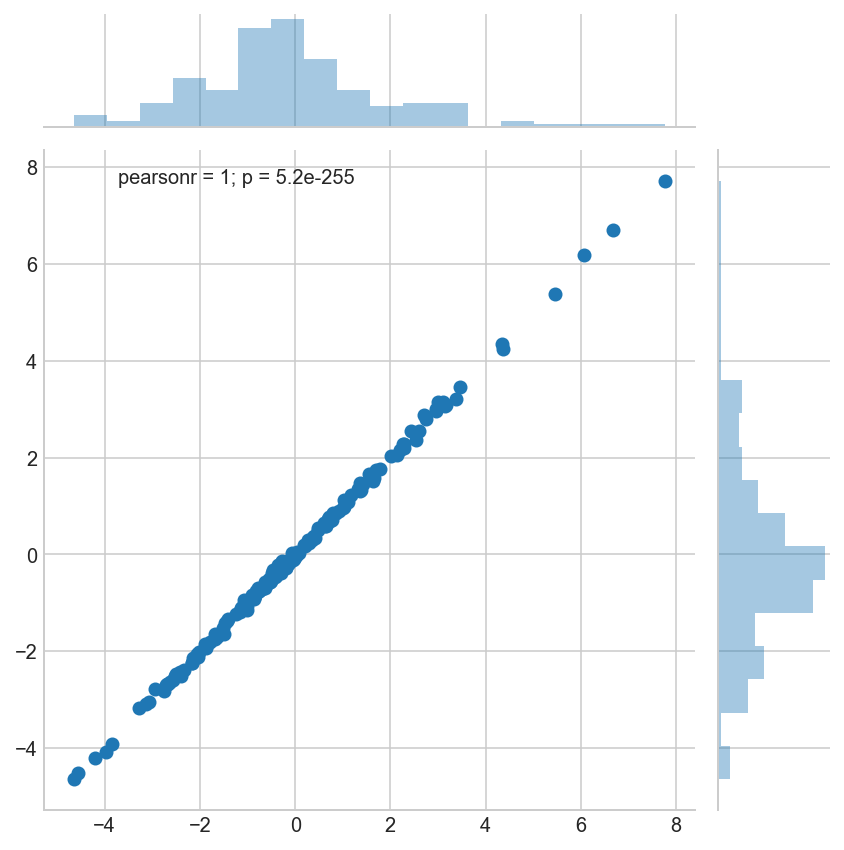

In [128]:
sns.jointplot(ridge_resid_q2, lasso_resid_q2)

## quite linear, seems rather normally distributed

###  Lets go with Lasso! Again!

In [129]:
lasso_q2.fit(X_train_q2, y_train_q2)

Lasso(alpha=0.010195238493851573, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [130]:
# View coefficients.
lasso_coefs_q2 = pd.DataFrame({'variable':TRAINSET_q2.drop('residuals', axis=1).columns,
                            'coef':lasso_q2.coef_,
                            'abs_coef':np.abs(lasso_q2.coef_)})

lasso_coefs_q2.sort_values('variable', inplace=True, ascending=False)

lasso_coefs_q2 #(Take a peek)

abs_coef      coef        variable
0   0.084866  0.084866     OverallQual
1   0.336095  0.336095     OverallCond
11  0.579847  0.579847  KitchenQual_TA
10  0.000000 -0.000000  KitchenQual_Gd
9   0.398071  0.398071  KitchenQual_Fa
16  0.399072 -0.399072   GarageQual_TA
15  0.039156  0.039156   GarageQual_Po
14  0.096659 -0.096659   GarageQual_NA
13  0.000000 -0.000000   GarageQual_Gd
12  0.282547  0.282547   GarageQual_Fa
31  0.000000  0.000000      FullBath_3
30  0.000000 -0.000000      FullBath_2
29  0.219890  0.219890      FullBath_1
28  0.043412 -0.043412        Fence_NA
27  0.037586 -0.037586      Fence_MnWw
26  0.040404  0.040404     Fence_MnPrv
25  0.050169 -0.050169      Fence_GdWo
4   0.623311  0.623311    ExterQual_TA
3   0.000000  0.000000    ExterQual_Gd
2   0.156979  0.156979    ExterQual_Fa
20  0.108284 -0.108284    ExterCond_TA
19  0.000000  0.000000    ExterCond_Po
18  0.000000  0.000000    ExterCond_Gd
17  0.062140  0.062140    ExterCond_Fa
8   1.608177  1.608177     BsmtQual_TA
7   0.254269  0.254269     BsmtQual_NA
6   0.171820  0.171820     BsmtQual_Gd
5   0.654198  0.654198     BsmtQual_Fa
36  0.000000 -0.000000  BsmtHalfBath_2
35  0.068955 -0.068955  BsmtHalfBath_1
34  0.018529 -0.018529  BsmtFullBath_3
33  0.030995  0.030995  BsmtFullBath_2
32  0.086247 -0.086247  BsmtFullBath_1
24  0.331759 -0.331759     BsmtCond_TA
23  0.000000 -0.000000     BsmtCond_Po
22  0.077318  0.077318     BsmtCond_NA
21  0.288451 -0.288451     BsmtCond_Gd

In [131]:
print 'Percent variables zeroed out:', np.sum((lasso_q2.coef_ == 0))/float(len(lasso_q2.coef_))

Percent variables zeroed out: 0.24324324324324326


### I can't drop those 0 coef variables, as I am already comparing them to those variables that have been dropped. 
#### I need to use the dropped variables as bases.

In [132]:
residential_log['BsmtCond'].value_counts() ##Comparison to BsmtCond Fa

TA    1299
Gd      65
Fa      43
NA      37
Po       2
Name: BsmtCond, dtype: int64

In [133]:
residential_log['BsmtFullBath'].value_counts() ##Comparison to BsmtFullBath 0

0    846
1    585
2     14
3      1
Name: BsmtFullBath, dtype: int64

In [134]:
residential_log['BsmtHalfBath'].value_counts() ##Comparison to BsmtHalfBath 0

0    1366
1      78
2       2
Name: BsmtHalfBath, dtype: int64

In [135]:
residential_log['BsmtQual'].value_counts() ##Comparison to BsmtQual Ex

TA    639
Gd    618
Ex    117
NA     37
Fa     35
Name: BsmtQual, dtype: int64

In [136]:
residential_log['ExterCond'].value_counts() ##Comparison to ExterCond Ex

TA    1271
Gd     145
Fa      26
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [137]:
residential_log['ExterQual'].value_counts() ##Comparison to ExterQual Ex

TA    899
Gd    487
Ex     49
Fa     11
Name: ExterQual, dtype: int64

In [138]:
residential_log['Fence'].value_counts() ##Comparison to Fence GdPrv

NA       1169
MnPrv     154
GdPrv      59
GdWo       53
MnWw       11
Name: Fence, dtype: int64

In [139]:
residential_log['GarageQual'].value_counts() ##Comparison to GarageQual Ex

TA    1299
NA      79
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

In [140]:
residential_log['KitchenQual'].value_counts() ##Comparison to KitchenQual Ex

TA    727
Gd    586
Ex     96
Fa     37
Name: KitchenQual, dtype: int64

In [141]:
residential_log['FullBath'].value_counts() ##Comparison to FullBath 0

2    766
1    642
3     30
0      8
Name: FullBath, dtype: int64

## Revisit LinearRegression only using Lasso_q2's output features.

In [142]:
#lasso_selected_feat_q2 = lasso_coefs_q2[lasso_coefs_q2.abs_coef != 0]['variable'].tolist()
lasso_selected_feat_q2 = lasso_coefs_q2['variable'].tolist()

In [143]:
lasso_selected_feat_q2 = lasso_selected_feat_q2 + ['YrSold']

In [144]:
## (Reminder: TRAININGDATA IS ALREADY DUMMIED. EVERYTHING WAS DONE WITH DUMMIED OUT COLS)
TRAININGDATA2_q2 = TRAININGDATA_q2[lasso_selected_feat_q2].copy()

## ADD RESIDUALS AGAIN
TRAININGDATA2_q2['residuals'] = y_whole_residual

##SPLIT THE DATA INTO < 2010 AND == 2010
TESTSET2_q2 = TRAININGDATA2_q2[TRAININGDATA2_q2.YrSold == 2010].copy()
TRAINSET2_q2 = TRAININGDATA2_q2[TRAININGDATA2_q2.YrSold < 2010].copy()

In [145]:
## YrSold served is Purpose, we can drop it.
TESTSET2_q2.drop('YrSold', axis=1, inplace=True)
TRAINSET2_q2.drop('YrSold', axis=1, inplace=True)

In [146]:
ss = StandardScaler()

### Prepare for new model: model2_q2

In [147]:
## TRAINING SET 2 Q2 with Lasso_q2's non-zero features
# TRAINING [Training] set for Q2 with Lasso_q2's non-zero features
X_train2_q2 = TRAINSET2_q2.drop('residuals', axis=1)
X_train2_q2 = ss.fit_transform(X_train2_q2) ##Standardize
# TRAINING [Test] set for Q2 with Lasso_q2's non-zero features
y_train2_q2 = TRAINSET2_q2['residuals'].values

## TESTING SET 2 Q2 with Lasso_q2's non-zero features
# TESTING [Training] set for Q2 with Lasso_q2's non-zero features
X_test2_q2 = TESTSET2_q2.drop('residuals', axis=1)
X_test2_q2 = ss.fit_transform(X_test2_q2) ##Standardize
# TESTING [Test] set for Q2 with Lasso_q2's non-zero features
y_test2_q2 = TESTSET2_q2['residuals'].values

In [148]:
TESTSET2_q2.shape

(172, 38)

In [149]:
model2_q2 = LinearRegression()
model2_q2.fit(X_train2_q2, y_train2_q2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [150]:
linreg_scores2_q2 = cross_val_score(model2_q2, X_train2_q2, y_train2_q2, cv=11) 
#print linreg_scores
print('LinearRegression with select features after Lasso: R2 score: {}'.format(np.mean(linreg_scores2_q2)))

LinearRegression with select features after Lasso: R2 score: 0.675044907344


#### Continue First... Don't panic

In [151]:
## Keep fingers crossed.
y_res_pred = model2_q2.predict(X_test2_q2)

In [152]:
print('Mean squared error: {}'.format(mean_squared_error(y_test2_q2, y_res_pred)))
print('Model Score R2: {}'.format(model2_q2.score(X_test2_q2, y_test2_q2)))
#print('Cross Validated R2: {}'.format(np.mean(cross_val_score(model2_q2, X_test2_q2,y_test2_q2, cv=9))))

Mean squared error: 4.09584480828
Model Score R2: 0.61248527816


#### Examine the coefficients

In [153]:
model2_coefs_q2 = pd.DataFrame({'variable':TRAINSET2_q2.drop('residuals', axis=1).columns,
                            'coef':model2_q2.coef_,
                            'abs_coef':np.abs(model2_q2.coef_)})

model2_coefs_q2.sort_values('coef', inplace=True, ascending=False)

model2_coefs_q2

abs_coef          coef        variable
24  1.704983e+00  1.704983e+00     BsmtQual_TA
17  7.194772e-01  7.194772e-01    ExterQual_TA
27  6.907574e-01  6.907574e-01     BsmtQual_Fa
2   6.208051e-01  6.208051e-01  KitchenQual_TA
4   4.210295e-01  4.210295e-01  KitchenQual_Fa
12  3.635267e-01  3.635267e-01      FullBath_1
1   3.357229e-01  3.357229e-01     OverallCond
26  2.604269e-01  2.604269e-01     BsmtQual_Gd
19  1.884558e-01  1.884558e-01    ExterQual_Fa
25  1.835033e-01  1.835033e-01     BsmtQual_NA
35  1.835033e-01  1.835033e-01     BsmtCond_NA
0   1.729948e-01  1.729948e-01     OverallQual
11  1.265660e-01  1.265660e-01      FullBath_2
18  8.488072e-02  8.488072e-02    ExterQual_Gd
31  5.106950e-02  5.106950e-02  BsmtFullBath_2
10  4.950642e-02  4.950642e-02      FullBath_3
23  4.333398e-02  4.333398e-02    ExterCond_Fa
9   4.274567e-02  4.274567e-02   GarageQual_Fa
15  3.891982e-02  3.891982e-02     Fence_MnPrv
3   2.029589e-02  2.029589e-02  KitchenQual_Gd
28  7.294596e-03  7.294596e-03  BsmtHalfBath_2
21  2.775558e-17 -2.775558e-17    ExterCond_Po
34  6.744750e-03 -6.744750e-03     BsmtCond_Po
6   1.707954e-02 -1.707954e-02   GarageQual_Po
30  2.735327e-02 -2.735327e-02  BsmtFullBath_3
14  4.933735e-02 -4.933735e-02      Fence_MnWw
22  5.027839e-02 -5.027839e-02    ExterCond_Gd
13  5.761709e-02 -5.761709e-02        Fence_NA
16  6.430924e-02 -6.430924e-02      Fence_GdWo
29  7.551990e-02 -7.551990e-02  BsmtHalfBath_1
32  8.019390e-02 -8.019390e-02  BsmtFullBath_1
8   1.435232e-01 -1.435232e-01   GarageQual_Gd
20  1.627267e-01 -1.627267e-01    ExterCond_TA
36  3.166710e-01 -3.166710e-01     BsmtCond_Gd
33  3.656176e-01 -3.656176e-01     BsmtCond_TA
7   4.037452e-01 -4.037452e-01   GarageQual_NA
5   8.058102e-01 -8.058102e-01   GarageQual_TA

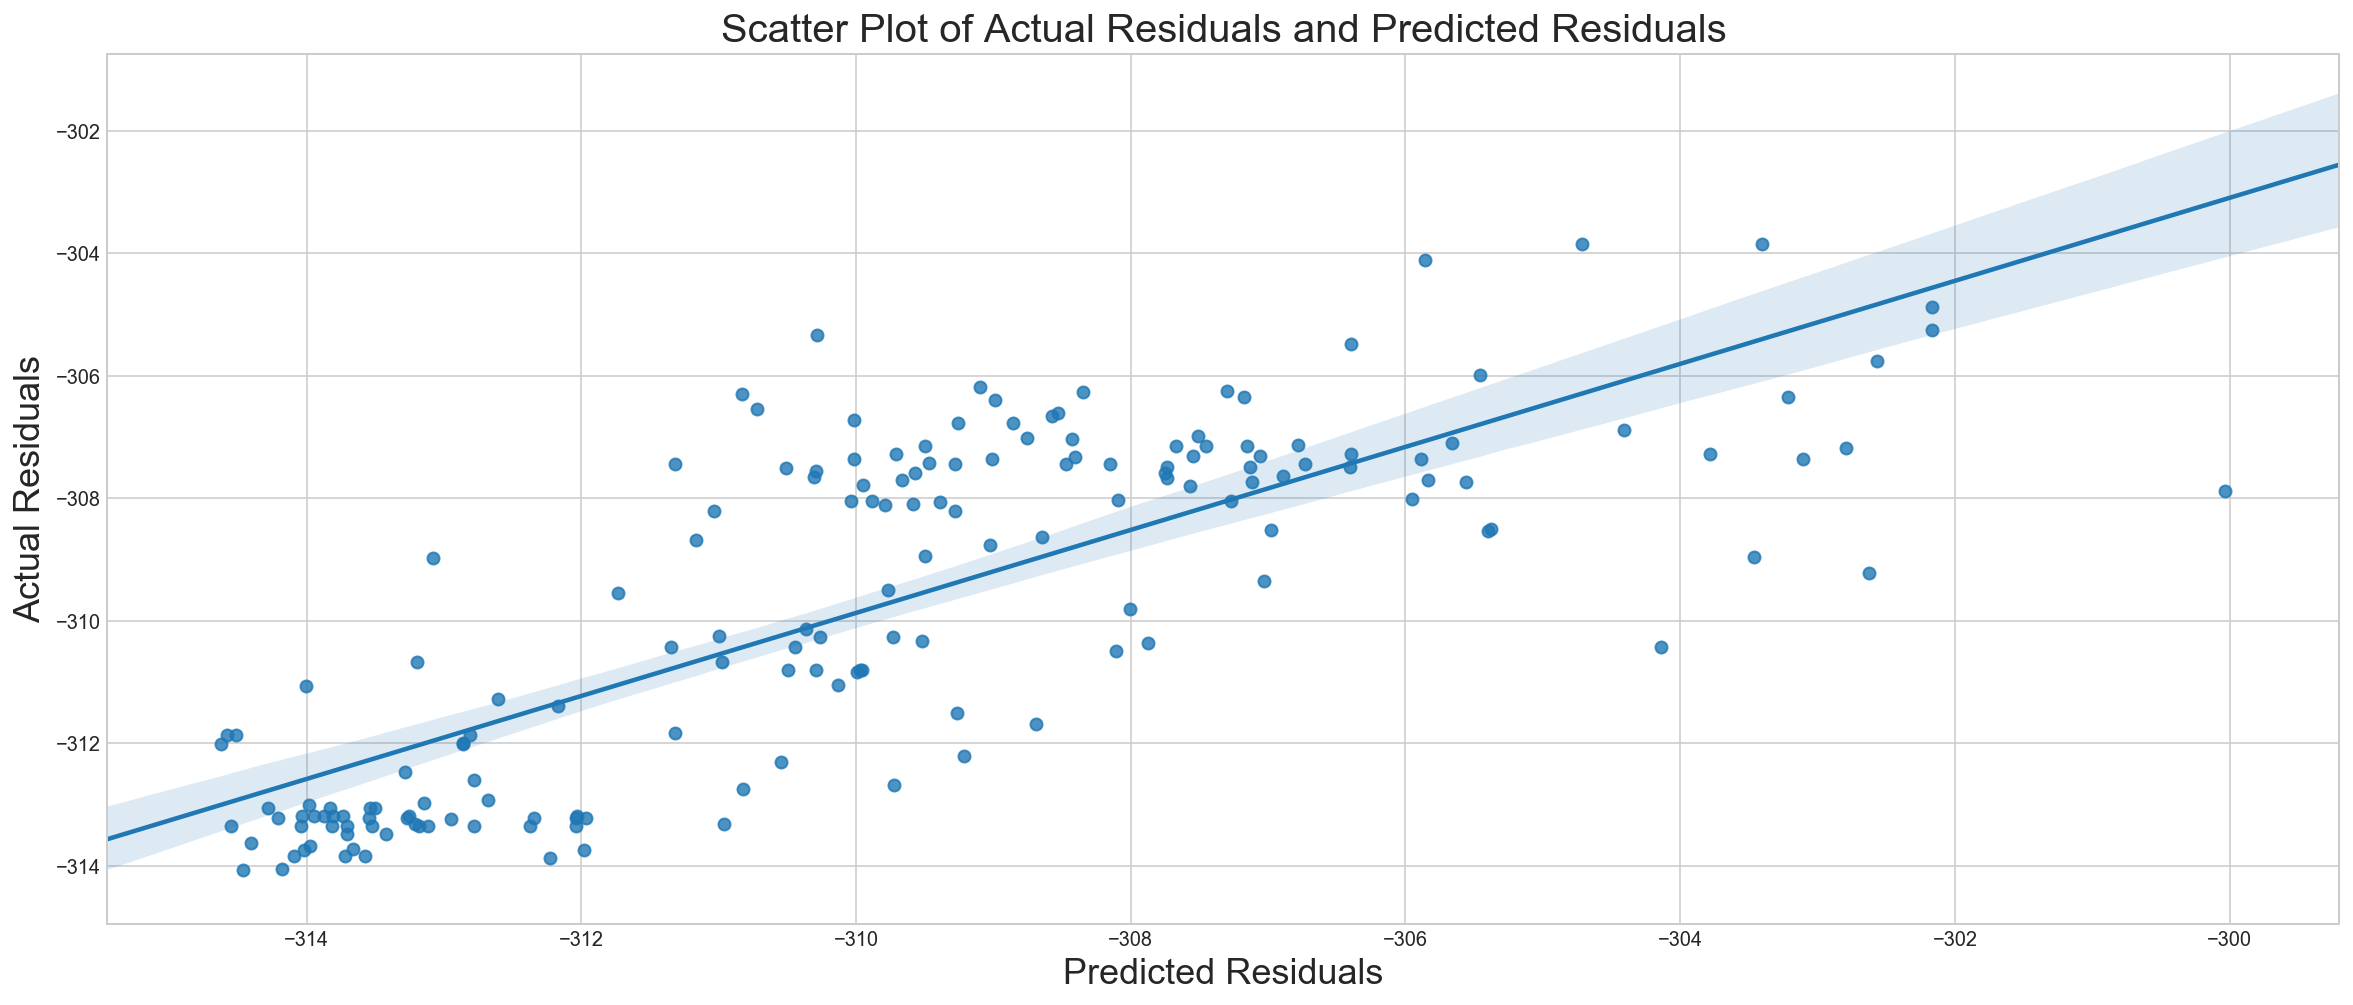

In [154]:
# Plot Residuals vs Predicted Residuals
plt.figure(figsize=(20,8))
sns.regplot(y_test2_q2, y_res_pred, fit_reg=True)

plt.title('Scatter Plot of Actual Residuals and Predicted Residuals', fontsize=20)
plt.xlabel('Predicted Residuals', fontsize=18)
plt.ylabel('Actual Residuals', fontsize=18)
plt.show()

## Ok looks 'right'

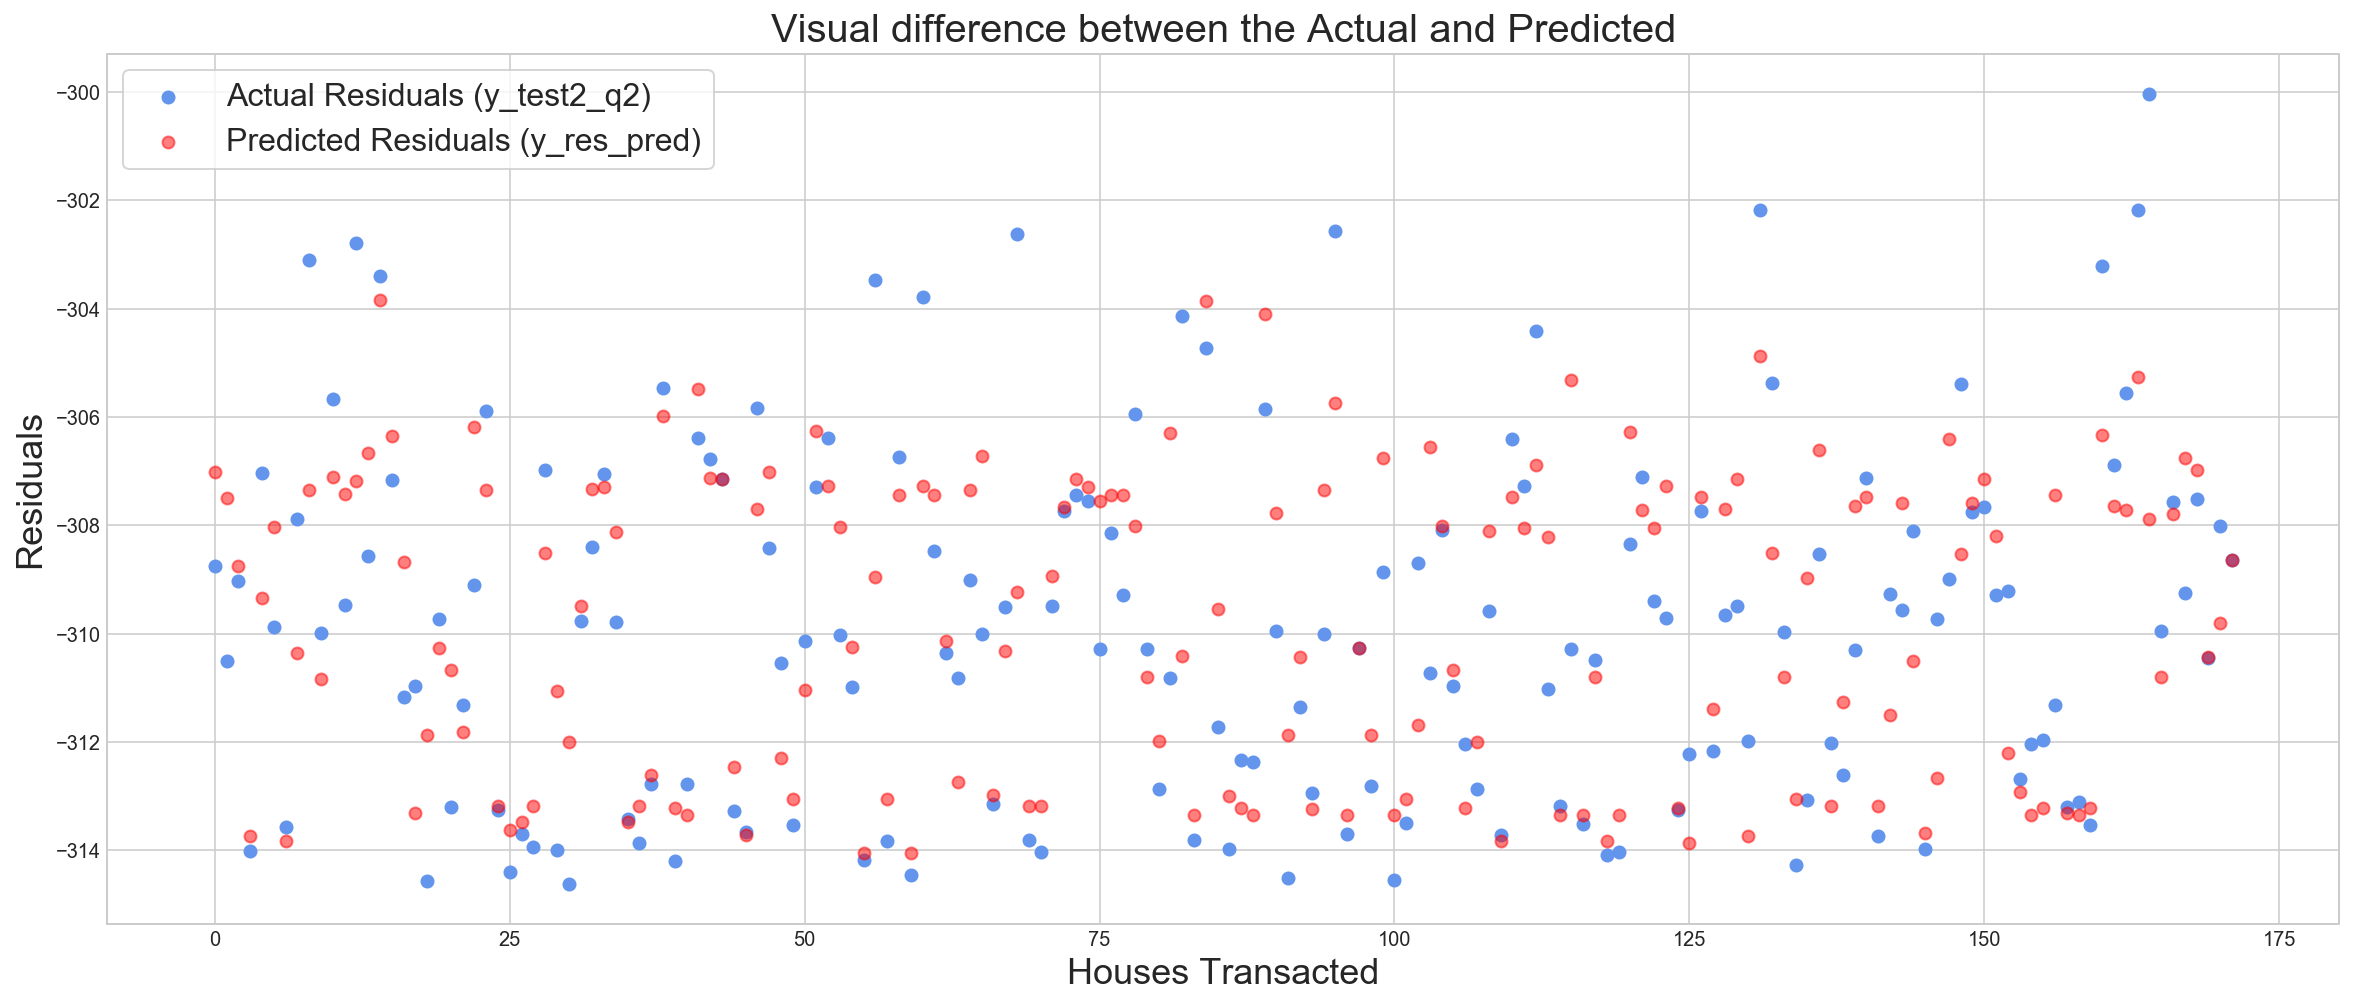

In [155]:
# Plot the Actual(y_test2_q2) and Predicted (y_res_pred)
# BLUE = Actual Residuals (y_test2_q2)
# RED =  Predicted Residuals (y_res_pred)

plt.figure(figsize=(20,8))
plt.scatter(range(len(y_test2_q2)), y_test2_q2,  color='cornflowerblue', label='Actual Residuals (y_test2_q2)') #Actual (y_test2)
plt.scatter(range(len(y_res_pred)), y_res_pred, color='red', alpha=0.5, label='Predicted Residuals (y_res_pred)') #Predicted (y_pred)

plt.legend(loc='upper left', prop={'size': 16}, frameon=True)

plt.title('Visual difference between the Actual and Predicted', fontsize=20)
plt.xlabel('Houses Transacted', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.show()

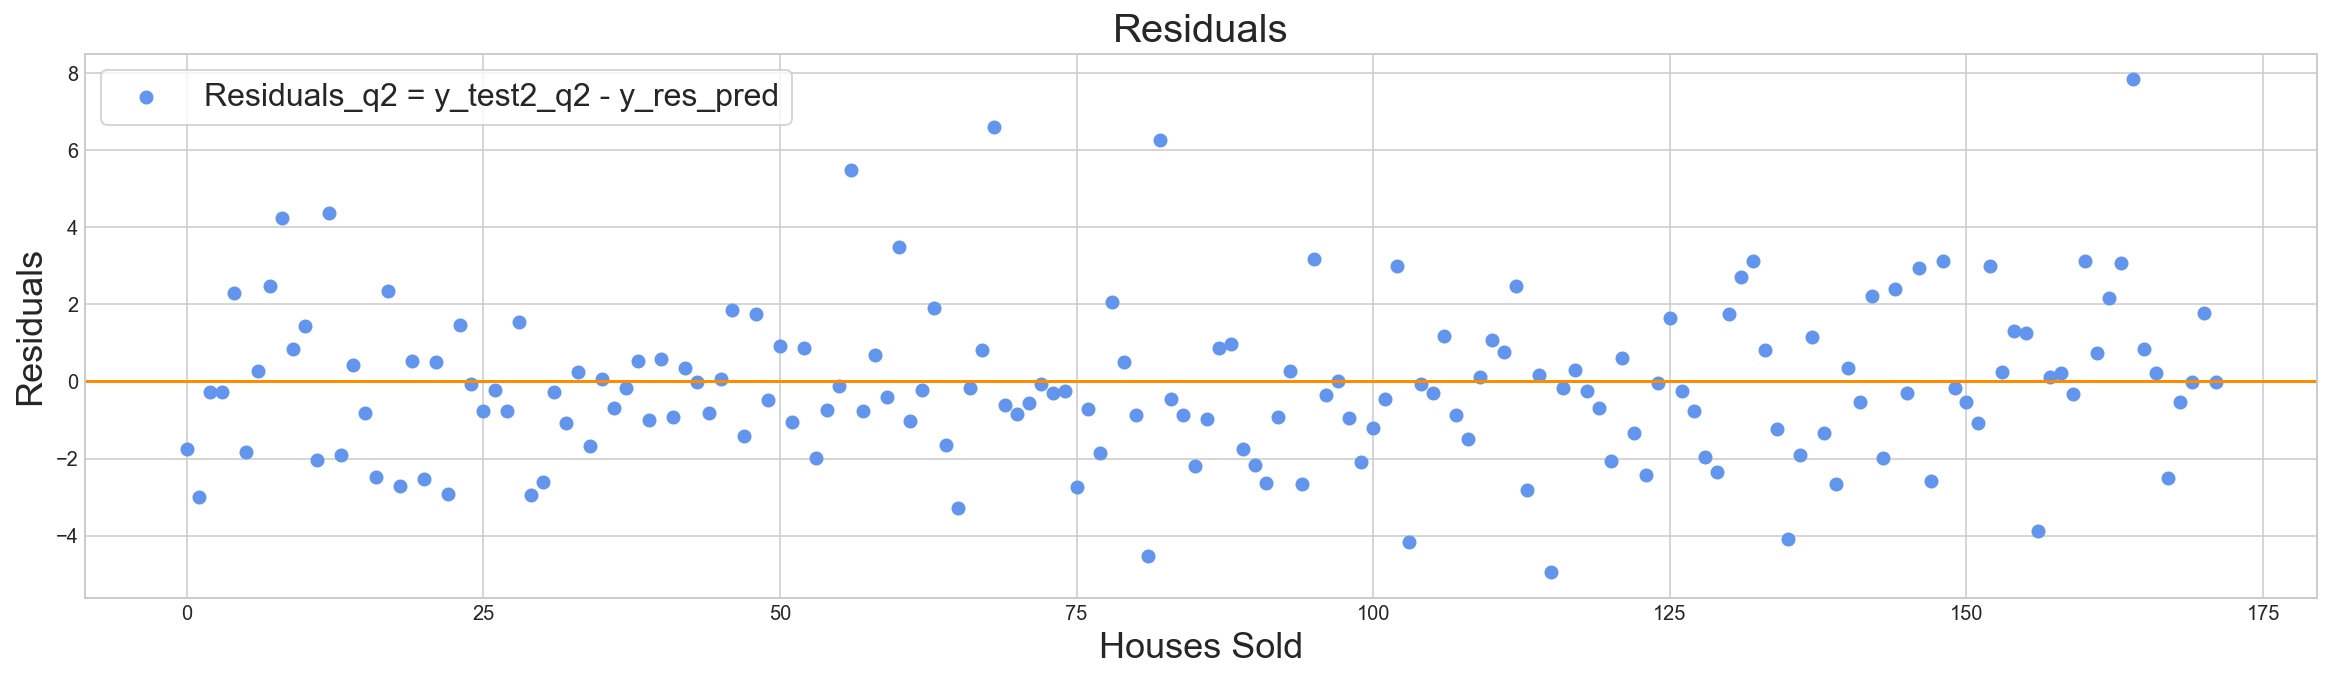

In [156]:
# Plot the Residuals = y_test2_q2 - y_res_pred
Residuals_q2 = y_test2_q2 - y_res_pred

plt.figure(figsize=(20,5))
plt.scatter(range(len(Residuals_q2)), Residuals_q2,  color='cornflowerblue', label='Residuals_q2 = y_test2_q2 - y_res_pred') #Residuals
#plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.5, label='Predicted Prices (y_pred)') #Predicted (y_pred)

plt.legend(loc='upper left', prop={'size': 16}, frameon=True)

plt.title('Residuals', fontsize=20)
plt.xlabel('Houses Sold', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.axhline(y=0, color='darkorange')  ## the 0 line to see how far the residuals are.
plt.show()

### Running StatsModels to see the Pvalues & Coefficients

In [157]:
## Add Constant
X2 = np.concatenate([X_train2_q2, np.ones((X_train2_q2.shape[0], 1))], axis=1)

model_ols = sm.OLS(y_train2_q2, X2).fit()

prediction = model_ols.predict(X2)

model_ols.summary(xname = TRAINSET2_q2.drop(['residuals'], axis=1).columns.tolist()+['Constant'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     82.55
Date:                Sat, 14 Jul 2018   Prob (F-statistic):          9.70e-295
Time:                        23:42:50   Log-Likelihood:                -2634.1
No. Observations:                1274   AIC:                             5340.
Df Residuals:                    1238   BIC:                             5526.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
OverallQual        0.1730      0.096      1.793      0.073      -0.016       0.362
OverallCond        0.3357      0.065      5.143      0.000       0.208       0.464
KitchenQual_TA     0.6208      0.155      3.996      0.000       0.316       0.926
KitchenQual_Gd     0.0203      0.138      0.147      0.883      -0.250       0.291
KitchenQual_Fa     0.4210      0.076      5.519      0.000       0.271       0.571
GarageQual_TA     -0.8058      0.350     -2.305      0.021      -1.492      -0.120
GarageQual_Po     -0.0171      0.083     -0.206      0.837      -0.180       0.146
GarageQual_NA     -0.4037      0.262     -1.542      0.123      -0.917       0.110
GarageQual_Gd     -0.1435      0.130     -1.103      0.270      -0.399       0.112
GarageQual_Fa      0.0427      0.221      0.194      0.846      -0.390       0.476
FullBath_3         0.0495      0.153      0.323      0.746      -0.251       0.350
FullBath_2         0.1266      0.484      0.262      0.794      -0.822       1.076
FullBath_1         0.3635      0.482      0.754      0.451      -0.582       1.309
Fence_NA          -0.0576      0.112     -0.514      0.607      -0.277       0.162
Fence_MnWw        -0.0493      0.060     -0.816      0.415      -0.168       0.069
Fence_MnPrv        0.0389      0.098      0.397      0.692      -0.154       0.231
Fence_GdWo        -0.0643      0.077     -0.838      0.402      -0.215       0.086
ExterQual_TA       0.7195      0.210      3.427      0.001       0.308       1.131
ExterQual_Gd       0.0849      0.187      0.453      0.651      -0.283       0.453
ExterQual_Fa       0.1885      0.071      2.637      0.008       0.048       0.329
ExterCond_TA      -0.1627      0.376     -0.433      0.665      -0.900       0.574
ExterCond_Po    1.255e-14   2.99e-16     42.009      0.000     1.2e-14    1.31e-14
ExterCond_Gd      -0.0503      0.348     -0.145      0.885      -0.733       0.632
ExterCond_Fa       0.0433      0.164      0.264      0.792      -0.278       0.365
BsmtQual_TA        1.7050      0.149     11.435      0.000       1.412       1.997
BsmtQual_NA        0.1835      0.044      4.138      0.000       0.096       0.271
BsmtQual_Gd        0.2604      0.128      2.038      0.042       0.010       0.511
BsmtQual_Fa        0.6908      0.075      9.166      0.000       0.543       0.839
BsmtHalfBath_2     0.0073      0.058      0.125      0.900      -0.107       0.122
BsmtHalfBath_1    -0.0755      0.057     -1.336      0.182      -0.186       0.035
BsmtFullBath_3    -0.0274      0.056     -0.484      0.628      -0.138       0.083
BsmtFullBath_2     0.0511      0.060      0.853      0.394      -0.066       0.169
BsmtFullBath_1    -0.0802      0.059     -1.367      0.172      -0.195       0.035
BsmtCond_TA       -0.3656      0.103     -3.547      0.000      -0.568      -0.163
BsmtCond_Po 

### Convert the summary results into a DF, filter out variables with P-value < 0.05 to see the significant variables

In [158]:
sm_q2_coef = pd.DataFrame({'Variable':TRAINSET2_q2.drop(['residuals'], axis=1).columns.tolist()+['Constant'],
                            'P-value':model_ols.pvalues,
                            'Coef': model_ols.params,
                            'Abs Coef': abs(model_ols.params)
                            })

#Only take Pvalues that are lower than 0.05 (sorted by Coef)
Q2_DF = sm_q2_coef[sm_q2_coef['P-value'] < 0.05].sort_values('Coef', ascending=False)
# Take out the constant
Q2_DF_noConstant = Q2_DF[Q2_DF['Variable'] != 'Constant']
# Just to see the 'group' easier
Q2_DF_noConstant_sorted = Q2_DF_noConstant.sort_values('Abs Coef', ascending=False)


In [159]:
## IF the Residuals are POSITIVE -> effect is Increasing the distance between the predicted vs the actual. Vice Versa
## Need to be interpreted in the opposite direction: INVERT

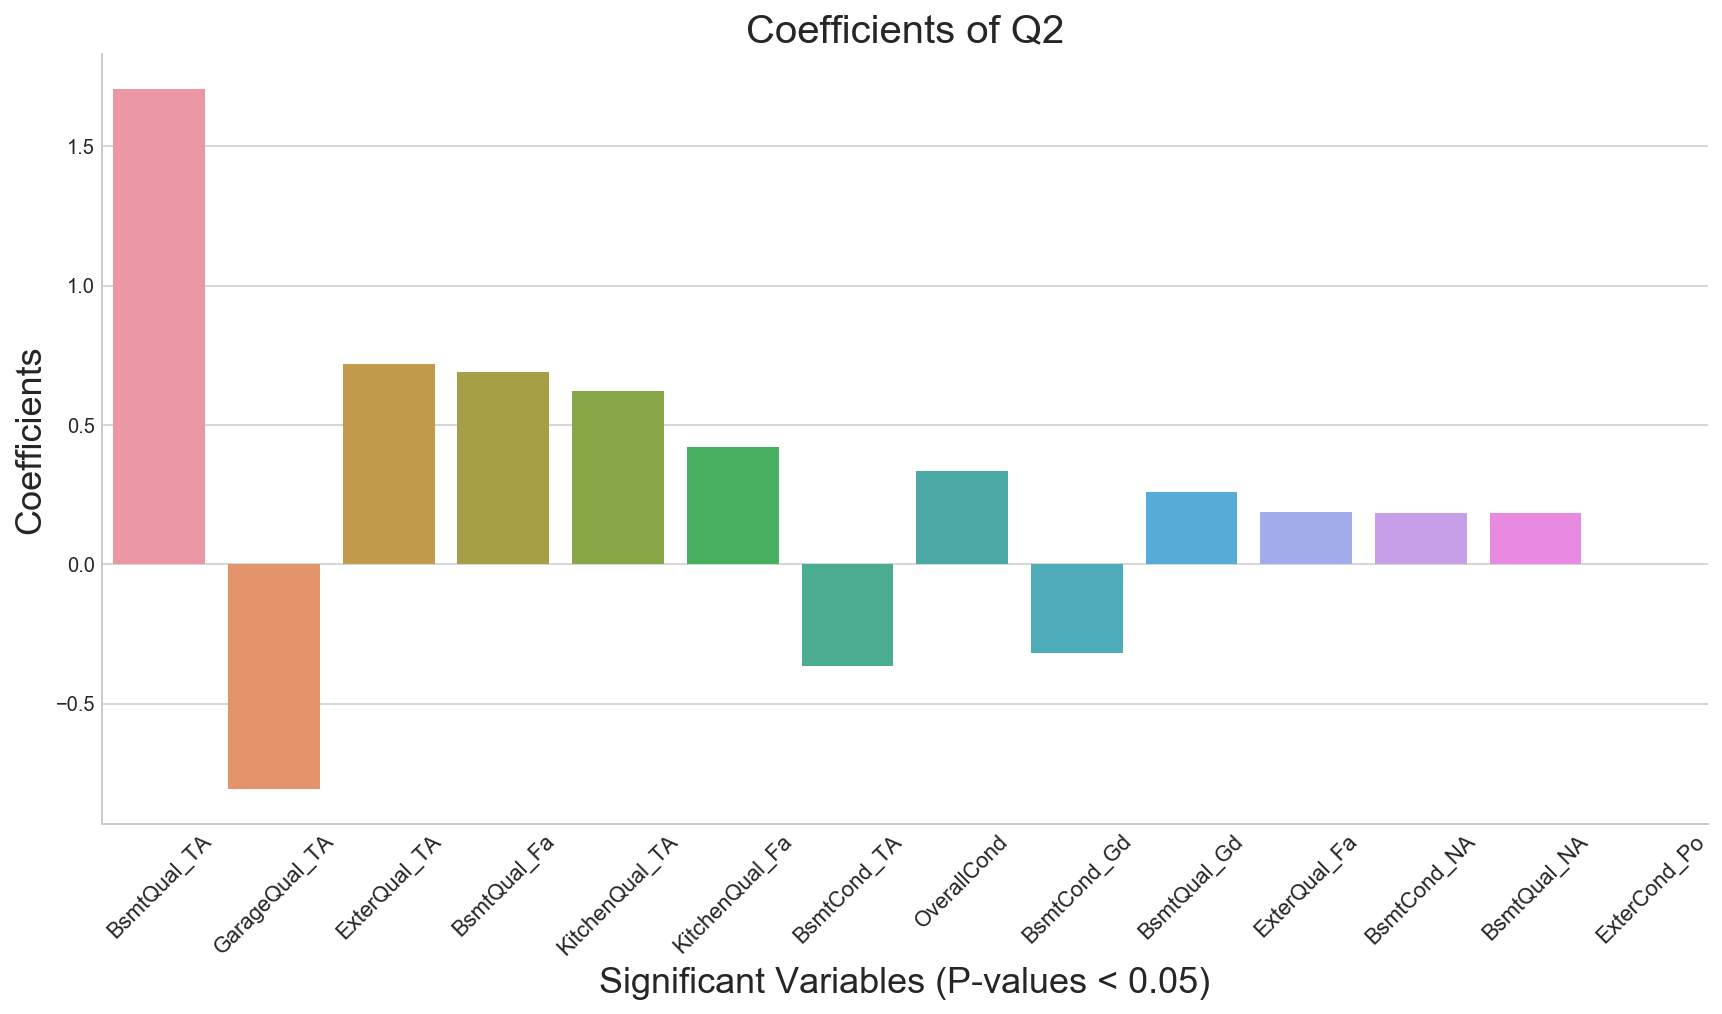

In [160]:
# Plot Coefficients
plt.figure(figsize=(20,8))
sns.factorplot(kind='bar', x='Variable', y='Coef', data=Q2_DF_noConstant_sorted, size=6, aspect=2)
plt.title('Coefficients of Q2', fontsize=20)
plt.xlabel('Significant Variables (P-values < 0.05)', fontsize=18)
plt.ylabel('Coefficients', fontsize=18)
plt.xticks(fontsize=11, rotation=45)
plt.show()

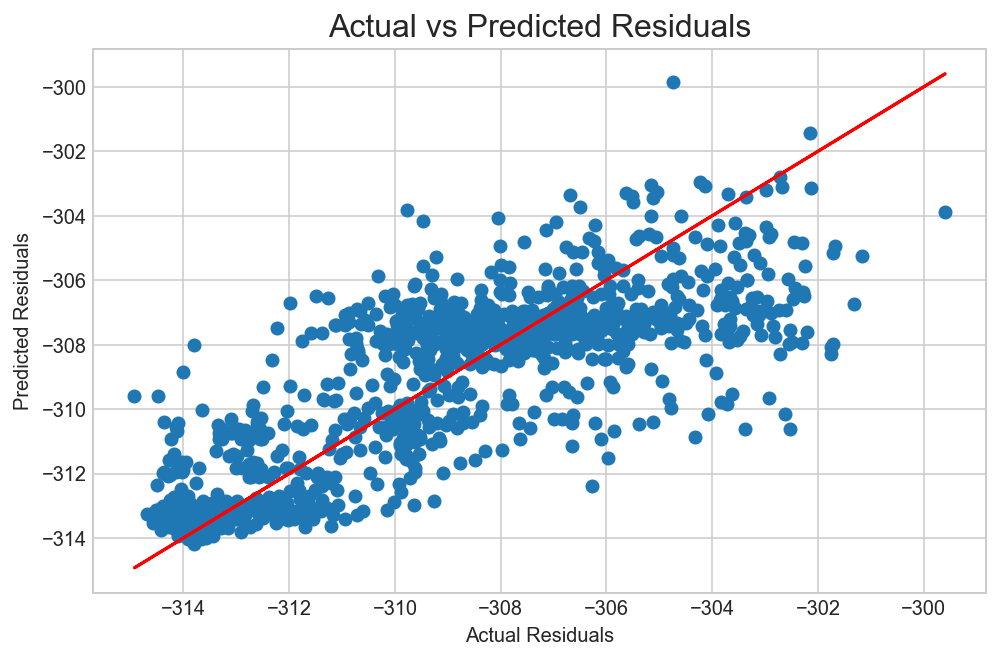

In [161]:
plt.figure(figsize=(8,5))
ax = plt.scatter(y_train2_q2, prediction)
plt.xlabel('Actual Residuals')
plt.ylabel('Predicted Residuals')
plt.title('Actual vs Predicted Residuals', fontsize=16)
ax = plt.plot(y_train2_q2,y_train2_q2, c='r')

<h2>Answering Q2:</h2>
<h3>Currently what we have from Q2 Model, attempting to explain the 12%:</h3>
<table style="height: 67px; width: 600px; border-color: #000000;" border="2">
<tbody>
<tr>
<td style="width: 60%; background-color: #d4f442; text-align: center;">Model in Q2 can only explain 60% of the predictions</td>
<td style="width: 40%; background-color: #42c5f4; text-align: center;">
<p align="center">Noise<br />+<br />Residuals:<br />40%</p>
</td>
</tr>
</tbody>
</table>
<p>The Q2 model accounts for 60% of the prediction variable, the remaining 40% are its residuals and noise.</p>
<ul>
<li><strong>The noise and the residuals are indistinguishable, we cannot differentiate one from the other.</strong></li>
<li>
<p><strong>Mean squared error: 2.78086488737</strong></p>
</li>
<li>
<p><strong>Model Score R2: 0.600459307608</strong></p>
</li>
</ul>
<h3>In Q2 we try to explain the Noise + Residuals of 12%</h3>
<ol>
<li><span style="color: #808080;">Evaluate the effect in dollars of the renovate-able features.</span>
<ul>
<li>
<h3>The 2 main metrics:</h3>
<ul>
<li><strong>OverallQual</strong>: Rates the overall material and finish of the house [Scale of 1-10]</li>
<li><strong>OverallCond</strong>: Rates the overall condition of the house&nbsp;[Scale of 1-10]</li>
</ul>
<p>For these Overall metrics, a 1 unit increase in predictor increases saleprice by (100 X coef)%</p>
<ul>
<li><strong>1 Unit increase in <span style="text-decoration: underline;">OverallQual</span> is a 100 X 0.1697 = <span style="background-color: #ccffff;">16.97% increase in the sale price</span>.</strong></li>
<li><strong>1 Unit increase in <span style="text-decoration: underline;">OverallCond</span> is a 100 X 0.2165 = <span style="background-color: #ccffff;">21.65% increase in the sale price.</span></strong></li>
</ul>
<h3><strong>"Good to have" Features to look out for:</strong></h3>
<ul>
<li><strong>BsmtQual:&nbsp;</strong>Evaluates the height of the basement (Baseline: BsmtQual Excellent)
<ul>
<li>For Houses with <strong>BmstQual TA</strong> would have a 100 X 1.4191 = <span style="background-color: #ccffff;"><strong>141.91 % higher SalePrice if it was renovated to BsmtQual Ex.</strong></span></li>
<li>For Houses with <strong>BmstQual NA (No Basement)</strong> would have a 100 X 0.1616 = <strong><span style="background-color: #ccffff;">16.16 % higher SalePriceif it was renovated to BsmtQual Ex.</span></strong></li>
<li>For Houses with <strong>BmstQual Gd</strong> would have a 100 X 0.2444 = <strong><span style="background-color: #ccffff;">24.44 % higher SalePrice if it was renovated to h BsmtQual Ex.</span></strong></li>
<li>For Houses with <strong>BmstQual Fa</strong> would have a 100 X 0.5563 = <span style="background-color: #ccffff;"><strong>55.63 % higher SalePriceif it was renovated to BsmtQual Ex.<br /><br /></strong></span></li>
</ul>
</li>
<li><strong>ExterQual:&nbsp;</strong>Evaluates the quality of the material on the exterior (Baseline: ExterQual Excellent)
<ul>
<li>For Houses with <strong>ExterQual TA</strong> would have a 100 X 0.5831 = <span style="background-color: #ccffff;"><strong>58.31 % higher SalePrice if it was renovated to ExterQual Ex.</strong></span></li>
<li>For Houses with <strong>ExterQual Fa</strong> would have a 100 X 0.1580 = <span style="background-color: #ccffff;"><strong>15.80 % higher SalePriceif it was renovated to BsmtQual Ex.<br /></strong></span></li>
</ul>
</li>
<li><strong>KitchenQual:&nbsp;</strong>Kitchen quality (Baseline:&nbsp;KitchenQual Excellent)
<ul>
<li>For Houses with&nbsp;<strong>KitchenQual</strong><strong>&nbsp;TA</strong> would have a 100 X 0.5364 = <span style="background-color: #ccffff;"><strong>53.64 % higher SalePrice if it was renovated to KitchenQual Ex.</strong></span></li>
<li>For Houses with&nbsp;<strong>KitchenQual</strong><strong>&nbsp;Fa</strong> would have a 100 X&nbsp;0.3604 = <span style="background-color: #ccffff;"><strong>36.04&nbsp;% higher SalePrice if it was renovated to KitchenQual Ex.</strong></span></li>
</ul>
</li>
<li><strong>BsmtCond:&nbsp;</strong>Basement condition (Baseline: BsmtCond Fair)
<ul>
<li>For Houses with&nbsp;<strong>BsmtCond</strong><strong>&nbsp;NA</strong> would have a 100 X 0.1616 = <span style="background-color: #ccffff;"><strong>16.16&nbsp;% higher SalePrice if it was renovated to BsmtCond Fa.</strong></span></li>
</ul>
</li>
</ul>
</li>
<li>
<h3>If Possible Avoid houses which:</h3>
<ul>
<li><span style="background-color: #ccffff;"><strong>Houses with ExterQual Po (Poor external quality of quality of the material on the exterior)</strong></span></li>
<li><span style="background-color: #ccffff;"><strong>BsmtCond Gd &amp; TA&nbsp; - Detrimental to the SalePrice, as compared to Bsmt Fa (baseline)</strong></span></li>
<li><span style="background-color: #ccffff;"><strong>MUST Avoid GarageQual TA!</strong></span></li>
</ul>
</li>
<li>
<h3>As the numbers don't make sense or follow any form of pricing logic we can conclude that:</h3>
<ul>
<li><span style="background-color: #ffff99;">The data has some problems in them and we may need to relook at the feature selection and engineering.</span></li>
<li><span style="background-color: #ffff99;">There is definitely influence by the noise in the model.</span>
<ul>
<li><span style="background-color: #ffff99;">Residuals are sale price which haven't been explained + noise</span></li>
<li><span style="background-color: #ffff99;">So the model may be explaining more of the noise then the residuals.</span><br /><br /></li>
</ul>
</li>
</ul>
</li>
</ul>
</li>
<li><span style="color: #808080;">How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money.</span>
<ul>
<li>The company can use the Q2 model mainly looking at the Overall Cond and Overall Qual metrics. If renovations on that property can increase the Overall Cond or Overall Qual by 1, there is a % increase in the price by at least 15% (See metrics explaination above)</li>
<li>After using the Q1 model to predict a market price + the median of the residuals ( -922.54), the company should aim to purchase the house at a lower price than that. (Actual value was LESS than the Predicted value)</li>
</ul>
</li>
<li><span style="color: #808080;">Investigate how much of the variance in price remaining is explained by these features.</span>
<ul>
<li>Of the 12% residual from the Q1 model, the Q2 model can only explain 60% of it. (R<sup>2&nbsp;</sup>= 0.60 in Q2 model)</li>
</ul>
</li>
<li><span style="color: #808080;">Do you trust your model? Should it be used to evaluate which properties to buy and fix up?</span>
<ul>
<li>Q1 model: <strong>Yes, if only to do a preliminary prediction.</strong></li>
<li>Q2 model:&nbsp;<strong>No, the renovatable + quality + condition features, do not explain the difference in price adequately. Should use the Q1 model to support the descision.</strong></li>
<li><strong>Do note:&nbsp;</strong>Both model does not account for external factors that also may affect a house price. Factors such as:<br />
<ul>
<li>Market conditions</li>
<li>Macro-economic conditions</li>
<li>Sale Conditions that are NOT Normal also attribute to the noise, as NOT Normal sales skew the actual market price of a house being sold.</li>
</ul>
</li>
</ul>
</li>
</ol>
<p>&nbsp;</p>

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

## PREPARE DATASET

### Feature engineer SaleCondition

In [162]:
residential_log['SaleCondition'].value_counts()/len(residential_log)

Normal     0.825035
Partial    0.085062
Abnorml    0.065698
Family     0.013831
Alloca     0.007607
AdjLand    0.002766
Name: SaleCondition, dtype: float64

In [163]:
## New Feature Is_Abnorml , 1 for yes, 0 for other.

f = lambda x: 1 if x=='Abnorml' else 0
residential_log['Is_Abnorml'] = residential_log['SaleCondition'].apply(f)

In [164]:
no_reno_features_noncat = ['OverallQual',
                            'GrLivArea',
                            'TotalBsmtSF',
                            'GarageArea',
                            '1stFlrSF',
                            'YearBuilt',
                            'YearRemodAdd',
                            'LotArea']

## TO DUMMYOUT.
no_reno_features_cat = ['Neighborhood',
                        'BldgType',
                        'OverallCond', 
                        'BsmtQual']

## ALL Non-renovatable Features
no_reno_features = no_reno_features_noncat + no_reno_features_cat
no_reno_features

['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageArea',
 '1stFlrSF',
 'YearBuilt',
 'YearRemodAdd',
 'LotArea',
 'Neighborhood',
 'BldgType',
 'OverallCond',
 'BsmtQual']

In [165]:
reno_features_cat = ['MasVnrType',
 'LotConfig',
 'GarageQual',
 'Exterior1st',
 'GarageFinish',
 'GarageYrBlt',
 'Electrical',
 'HouseStyle',
 'MasVnrArea',
 'Foundation',
 'GarageType',
 'BsmtCond',
 'HeatingQC',
 'RoofStyle',
 'CentralAir',
 'BsmtExposure',
 'Utilities',
 'LotShape',
 'MiscFeature',
 'PavedDrive',
 'LandSlope',
 'SaleType',
 'MSZoning',
 'Exterior2nd',
 'Heating',
 'MSSubClass',
 'FireplaceQu',
 'KitchenQual',
 'BsmtFinType2',
 'BsmtFinType1',
 'Condition2',
 'Condition1',
 'GarageCond',
 'LandContour',
 'RoofMatl',
 'Fence',
 'ExterCond',
 'ExterQual',
 'Functional',
 'Alley',
 'Street',
 'PoolQC'] ##Removed SaleCondition

reno_features_NeedToDummy_noncat = ['FullBath', 'Fireplaces', 'TotRmsAbvGrd', 'BsmtFullBath', 'BsmtHalfBath','BedroomAbvGr', 'KitchenAbvGr']

TO_DUMMY_OUT = reno_features_cat + reno_features_NeedToDummy_noncat

reno_features_noncat = ['LotFrontage', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', '2ndFlrSF', 'LowQualFinSF']

In [166]:
NODUMMY = no_reno_features_noncat+reno_features_noncat
TODUMMY = no_reno_features_cat+reno_features_cat+reno_features_NeedToDummy_noncat

ALLFEATS = NODUMMY+TODUMMY+ ['YrSold','SalePrice','Is_Abnorml'] ## Add in Engineered feature

In [167]:
## TRAININGDATA from Residential_log
Q3_DATA = residential_log[ALLFEATS].copy()

## Dummy out
Q3_DATA = pd.get_dummies(Q3_DATA, columns=TODUMMY, drop_first=True)

print Q3_DATA.shape

(1446, 713)


In [168]:
## Literally, putting EVERYTHING in, and letting the Tree decide.

<h2>XGBoost</h2>
<h3>XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.</h3>
https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

In [169]:
X_xgb = Q3_DATA.drop('Is_Abnorml', axis=1)
y_xgb = Q3_DATA['Is_Abnorml']

print('There are {} positive instances.'.format(y_xgb.sum()))
print(len(Q3_DATA))

There are 95 positive instances.
1446


X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.33, random_state=seed)

print('Total number of positive test instances: {}'.format(y_test_xgb.sum()))

X_test_xgb['Is_Abnorml'] = y_test_xgb
Q3_DATA_TEST = X_test_xgb

X_train_xgb['Is_Abnorml'] = y_train_xgb
Q3_DATA_TRAIN = X_train_xgb

In [170]:
# train = pd.read_csv('train_modified.csv')
# target = 'Disbursed'
# IDcol = 'ID'
# train = Q3_DATA_TRAIN
# target = 'Is_Abnorml'
# IDcol = ''
train = Q3_DATA
target = 'Is_Abnorml'
IDcol = ''

In [171]:
def modelfit_test(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
        ## A "Confusion Matrix"
    conmat =  pd.crosstab(
        pd.Series(dtrain[target].values, name='Actual'),
        pd.Series(dtrain_predprob, name='Predicted'),
        margins = True
    )
    
    return conmat

In [185]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50, cutoff=0.5):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob)
    print classification_report(dtrain[target].values, dtrain_predictions)
    
#     fpr, tpr, thresholds = roc_curve(dtrain[target], dtrain_predprob)
#     print "AUC: {}".format(auc(fpr, tpr))
    

                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    ## Introduce a Cut off
    
    print('-'*30)
    print dtrain_predprob
    print('Min dtrain_prob: {}'.format(min(dtrain_predprob)))
    print('Max dtrain_prob: {}'.format(max(dtrain_predprob)))
    print('-'*30)
    print cutoff
    predicted1s = (dtrain_predprob > cutoff).astype('int')
    
#     cut_off = []
#     for i in range(0, 100, 1):
#         Y_pp['pred_class_thresh'] = [1 if x >= (float(i)/100) else 0 for x in Y_pp.class_1_pp.values]
#         cut_off.append(i)
    
    
    print('-'*30)
    print sum(predicted1s)
    ## A "Confusion Matrix"
    conmat =  pd.crosstab(
        pd.Series(dtrain[target].values, name='Actual'),
        pd.Series(predicted1s, name='Predicted'),
        margins = True
    )
    print('-'*30)
    print conmat

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9398
AUC Score (Train): 0.899408
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1351
          1       0.90      0.09      0.17        95

avg / total       0.94      0.94      0.92      1446

------------------------------
[0.18231304 0.18375546 0.18231304 ... 0.18231304 0.18532397 0.18296736]
0.17988834
0.58865565
------------------------------
0.5
------------------------------
10
------------------------------
Predicted     0   1   All
Actual                   
0          1350   1  1351
1            86   9    95
All        1436  10  1446


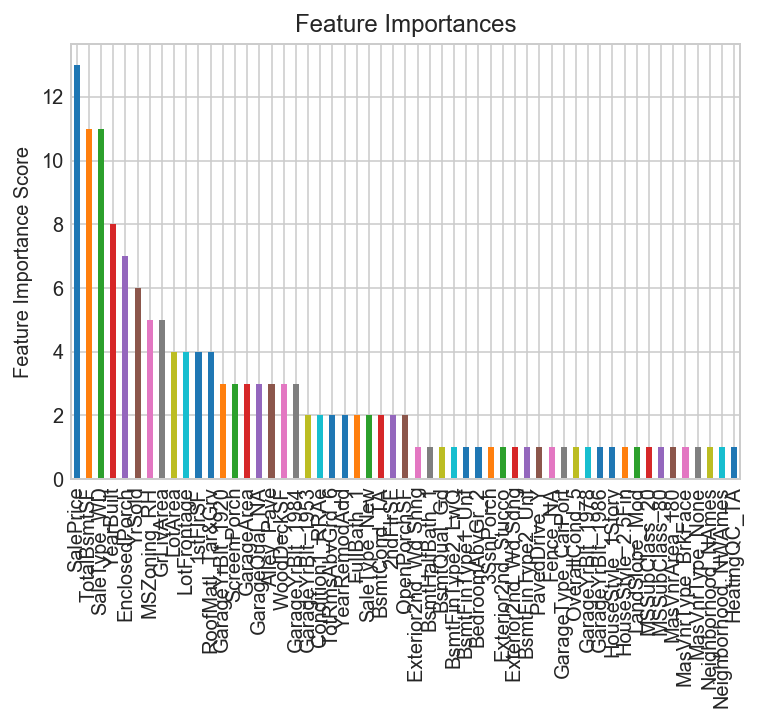

In [173]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors,0.5)

In [174]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68635, std: 0.02952, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.67415, std: 0.04320, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.67976, std: 0.05138, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.66475, std: 0.04828, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.64977, std: 0.04505, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.67112, std: 0.04069, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.66231, std: 0.03583, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.64785, std: 0.06105, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.66462, std: 0.05675, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.66212, std: 0.03722, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.65046, std: 0.05288, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.66744, std: 0.05786, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

In [175]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[1,2,3]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.70536, std: 0.03426, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.68161, std: 0.03997, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.67149, std: 0.04422, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.68635, std: 0.02952, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.67312, std: 0.03706, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.67415, std: 0.04320, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.68931, std: 0.03140, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.67339, std: 0.04383, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.65696, std: 0.04146, params: {'max_depth': 4, 'min_child_weight': 3}],
 {'max_depth': 2, 'min_child_weight': 1},
 0.7053642922394135)

In [176]:
param_test2b = {
 'min_child_weight':[0.5, 1, 1.5]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.67009, std: 0.03271, params: {'min_child_weight': 0.5},
  mean: 0.68931, std: 0.03140, params: {'min_child_weight': 1},
  mean: 0.67238, std: 0.03873, params: {'min_child_weight': 1.5}],
 {'min_child_weight': 1},
 0.6893069492098429)

In [177]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.66725, std: 0.06246, params: {'gamma': 0.0},
  mean: 0.67587, std: 0.05634, params: {'gamma': 0.1},
  mean: 0.67645, std: 0.06162, params: {'gamma': 0.2},
  mean: 0.68482, std: 0.06309, params: {'gamma': 0.3},
  mean: 0.69075, std: 0.06359, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 0.6907455600871798)

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9364
AUC Score (Train): 0.821228
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1351
          1       1.00      0.03      0.06        95

avg / total       0.94      0.94      0.91      1446

------------------------------
[0.15034603 0.15273441 0.15034603 ... 0.15034603 0.15390225 0.15273441]
0.15034603
0.5510558
------------------------------
0.5
------------------------------
3
------------------------------
Predicted     0  1   All
Actual                  
0          1351  0  1351
1            92  3    95
All        1443  3  1446


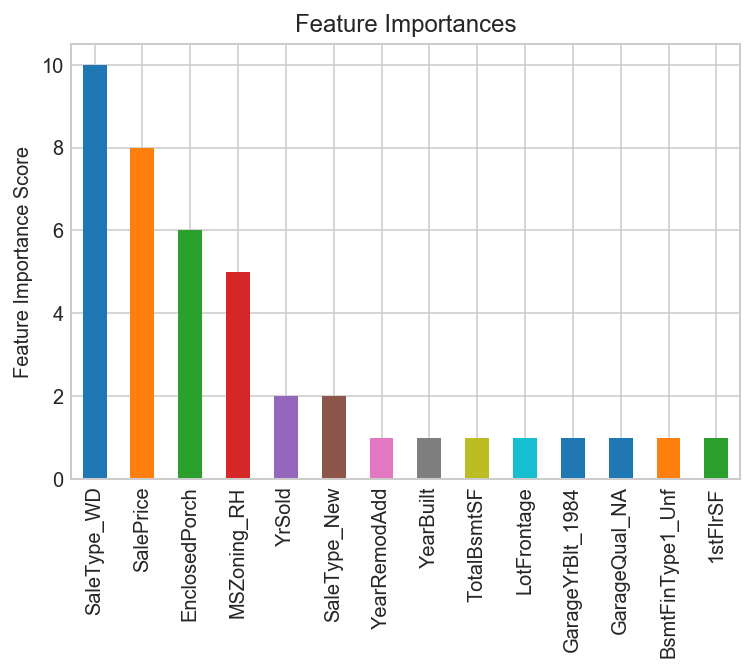

In [178]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors, 0.5)

In [179]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=2,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.67638, std: 0.04232, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.67160, std: 0.03679, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.68772, std: 0.03460, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.70049, std: 0.04806, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.68916, std: 0.04358, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.68347, std: 0.03671, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.68810, std: 0.03603, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.68827, std: 0.04170, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.67524, std: 0.04166, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.68371, std: 0.03298, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.69811, std: 0.02621, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.69301, std: 0.03965, params: {'subsample': 0.9, 'colsample_bytree'

In [180]:
param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=2,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.68593, std: 0.02906, params: {'subsample': 0.85, 'colsample_bytree': 0.55},
  mean: 0.68646, std: 0.03976, params: {'subsample': 0.9, 'colsample_bytree': 0.55},
  mean: 0.69950, std: 0.04484, params: {'subsample': 0.95, 'colsample_bytree': 0.55},
  mean: 0.69121, std: 0.03073, params: {'subsample': 0.85, 'colsample_bytree': 0.6},
  mean: 0.70049, std: 0.04806, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.70764, std: 0.05339, params: {'subsample': 0.95, 'colsample_bytree': 0.6},
  mean: 0.69409, std: 0.04196, params: {'subsample': 0.85, 'colsample_bytree': 0.65},
  mean: 0.69398, std: 0.04633, params: {'subsample': 0.9, 'colsample_bytree': 0.65},
  mean: 0.69310, std: 0.04473, params: {'subsample': 0.95, 'colsample_bytree': 0.65}],
 {'colsample_bytree': 0.6, 'subsample': 0.95},
 0.7076439150356416)

In [181]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=2,
 min_child_weight=1, gamma=0.4, subsample=0.95, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.70764, std: 0.05339, params: {'reg_alpha': 1e-05},
  mean: 0.69852, std: 0.04891, params: {'reg_alpha': 0.01},
  mean: 0.69880, std: 0.05606, params: {'reg_alpha': 0.1},
  mean: 0.68921, std: 0.04396, params: {'reg_alpha': 1},
  mean: 0.56127, std: 0.02641, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.7076439150356416)

In [182]:
param_test7 = {
 'reg_alpha':[0, 0.00001, 0.00005, 0.0001, 0.0005]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=2,
 min_child_weight=1, gamma=0.4, subsample=0.95, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27, reg_alpha = 1e-5), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.70764, std: 0.05339, params: {'reg_alpha': 0},
  mean: 0.70764, std: 0.05339, params: {'reg_alpha': 1e-05},
  mean: 0.70764, std: 0.05339, params: {'reg_alpha': 5e-05},
  mean: 0.70764, std: 0.05339, params: {'reg_alpha': 0.0001},
  mean: 0.70417, std: 0.05142, params: {'reg_alpha': 0.0005}],
 {'reg_alpha': 0},
 0.7076439150356416)

In [204]:
param_test8 = {
 'max_delta_step':[1,2,3,4,5,6,7,8,9]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=500, max_depth=2,
 min_child_weight=1, gamma=0.4, subsample=0.95, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27, max_delta_step=1,reg_alpha = 1e-5), 
 param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(train[predictors],train[target])
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.67573, std: 0.02357, params: {'max_delta_step': 1},
  mean: 0.66996, std: 0.03401, params: {'max_delta_step': 2},
  mean: 0.67339, std: 0.03437, params: {'max_delta_step': 3},
  mean: 0.67339, std: 0.03437, params: {'max_delta_step': 4},
  mean: 0.67339, std: 0.03437, params: {'max_delta_step': 5},
  mean: 0.67339, std: 0.03437, params: {'max_delta_step': 6},
  mean: 0.67339, std: 0.03437, params: {'max_delta_step': 7},
  mean: 0.67339, std: 0.03437, params: {'max_delta_step': 8},
  mean: 0.67339, std: 0.03437, params: {'max_delta_step': 9}],
 {'max_delta_step': 1},
 0.6757277572775727)

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9364
AUC Score (Train): 0.848775
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      1351
          1       1.00      0.03      0.06        95

avg / total       0.94      0.94      0.91      1446

------------------------------
[0.06542033 0.08045296 0.06172546 ... 0.06934526 0.06755639 0.08300649]
Min dtrain_prob: 0.0617254562676
Max dtrain_prob: 0.559801459312
------------------------------
0.5
------------------------------
3
------------------------------
Predicted     0  1   All
Actual                  
0          1351  0  1351
1            92  3    95
All        1443  3  1446


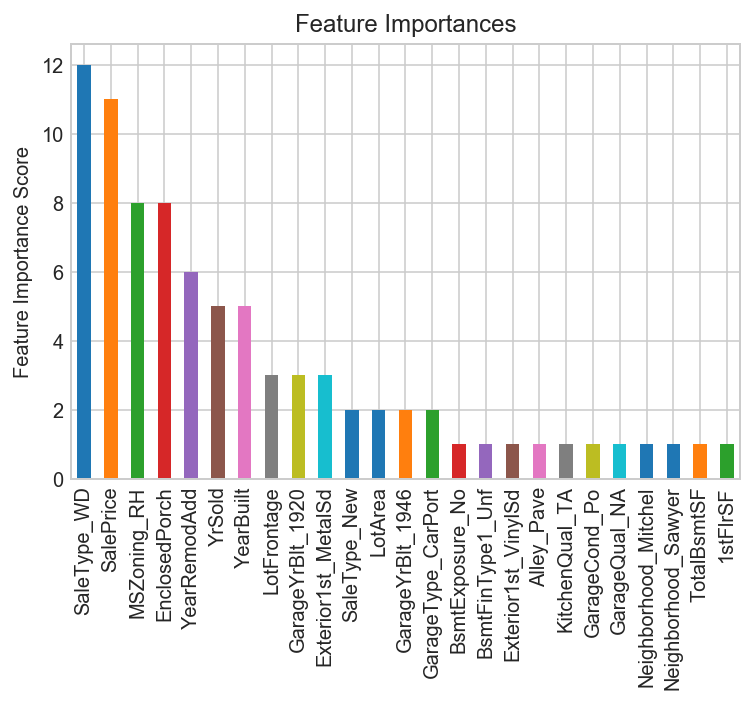

In [217]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.9,
 colsample_bytree=0.6,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 max_delta_step = 1)
modelfit(xgb3, train, predictors, 0.54)

/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9544
AUC Score (Train): 0.995613
             precision    recall  f1-score   support

          0       1.00      0.95      0.97      1351
          1       0.59      0.99      0.74        95

avg / total       0.97      0.95      0.96      1446

------------------------------
[0.15145232 0.21334961 0.17528674 ... 0.1397223  0.1846894  0.20536198]
Min dtrain_prob: 0.0911229625344
Max dtrain_prob: 0.878304123878
------------------------------
0.5
------------------------------
159
------------------------------
Predicted     0    1   All
Actual                    
0          1286   65  1351
1             1   94    95
All        1287  159  1446


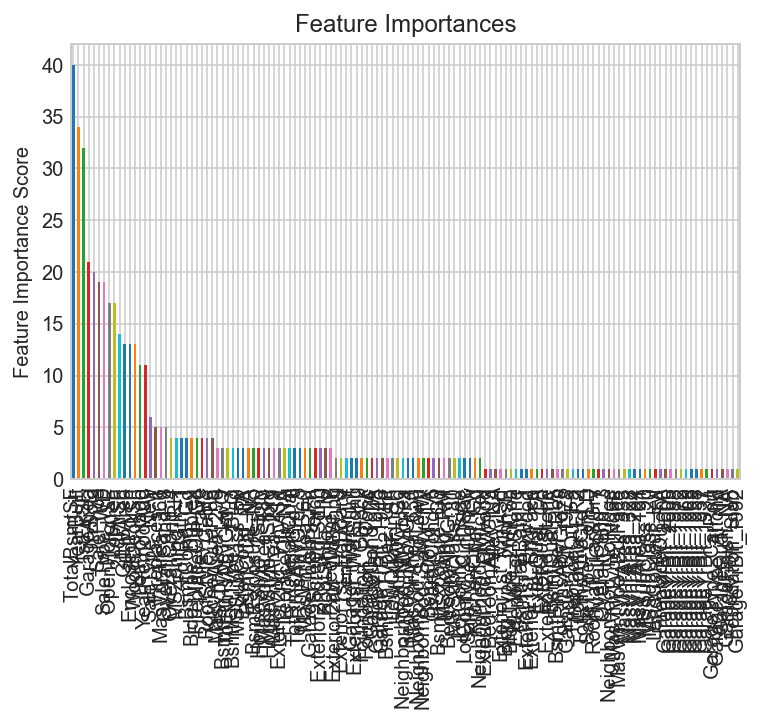

In [235]:
xgb3b = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.9,
 colsample_bytree=0.6,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=(1351./95),
 seed=27,
 max_delta_step = 1)
modelfit(xgb3b, train, predictors, 0.5)

In [236]:
xgb3bTEST = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.9,
 colsample_bytree=0.6,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=(1351./95),
 seed=27,
 max_delta_step = 1)

<h3>Taken from the XGBoost website:</h3>
<p><a href="http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html?highlight=auc">http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html?highlight=auc</a></p>
<h3>Handle Imbalanced Dataset</h3>
<p>For common cases such as ads clickthrough log, the dataset is extremely imbalanced. This can affect the training of xgboost model, and there are two ways to improve it.</p>
<ul class="simple">
<li>If you care only about the ranking order (AUC) of your prediction
<ul>
<li><span style="background-color: #00ffff;">Balance the positive and negative weights, via&nbsp;<code class="docutils literal"><span class="pre">scale_pos_weight</span></code></span></li>
<li><span style="background-color: #00ffff;">Use AUC for evaluation</span></li>
</ul>
</li>
<li>If you care about predicting the right probability
<ul>
<li>In such a case, you cannot re-balance the dataset</li>
<li>In such a case, set parameter&nbsp;<code class="docutils literal"><span class="pre">max_delta_step</span></code>&nbsp;to a finite number (say 1) will help convergence</li>
</ul>
</li>
</ul>